# Generative Adversarial Network

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

## Set Arguments

In [4]:
num_workers = 0
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400

In [5]:
img_shape = (channels, img_size, img_size)

In [6]:
cuda = True if torch.cuda.is_available() else False

## Configure Data Loader

In [7]:
os.makedirs("images/gan/", exist_ok=True)

In [8]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform=transforms.Compose(
                       [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
                   ),
                   batch_size = batch_size,
                   shuffle = True,
)

In [9]:
print('Total digit batches:',len(data_loader))

Total digit batches: 938


## Build GAN Architecture

<img src='images/gan-architecture.jpg'/>

## Generator

In [10]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_features, out_features, normalize=True):
            layers = [nn.Linear(in_features, out_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh(),
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0),*img_shape)
        
        return img

## Discriminator

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        
        return validity

#### Initialize the generator and discriminator

In [12]:
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

## Loss Function

In [13]:
adversarial_loss = torch.nn.BCELoss()
if cuda: adversarial_loss.cuda()

## Optimizers

In [14]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [15]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training the [Network](https://arxiv.org/pdf/1406.2661.pdf)

In [16]:
n_epochs = 10 # theoretically should be high

In [17]:
for epoch in range(n_epochs):
    
    g_loss_to_display = []
    d_loss_to_display = []
    for i, (imgs, _) in enumerate(data_loader):
        
        # adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        # configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # ----------------
        # Train Generator
        # ----------------
        optimizer_G.zero_grad()
        
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # generate a batch of images
        gen_imgs = generator(z)
        
        # loss measures the generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss_to_display.append(g_loss)
        g_loss.backward()
        
        optimizer_G.step()
        
        # -------------------
        # Train Discriminator
        # -------------------
        
        optimizer_D.zero_grad()
        
        # measure the discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss_to_display.append(d_loss)
        d_loss.backward()
        
        optimizer_D.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [Generator loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), g_loss.item(), d_loss.item())
        )
        
        batches_done = epoch * len(data_loader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/gan/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/10] [Batch 0/938] [Generator loss: 0.710277] [Discriminator loss: 0.690868]
[Epoch 0/10] [Batch 1/938] [Generator loss: 0.707603] [Discriminator loss: 0.607259]
[Epoch 0/10] [Batch 2/938] [Generator loss: 0.704998] [Discriminator loss: 0.541152]
[Epoch 0/10] [Batch 3/938] [Generator loss: 0.702594] [Discriminator loss: 0.488264]
[Epoch 0/10] [Batch 4/938] [Generator loss: 0.698821] [Discriminator loss: 0.442328]
[Epoch 0/10] [Batch 5/938] [Generator loss: 0.694928] [Discriminator loss: 0.414568]
[Epoch 0/10] [Batch 6/938] [Generator loss: 0.688879] [Discriminator loss: 0.397342]
[Epoch 0/10] [Batch 7/938] [Generator loss: 0.681840] [Discriminator loss: 0.384847]
[Epoch 0/10] [Batch 8/938] [Generator loss: 0.673549] [Discriminator loss: 0.378916]
[Epoch 0/10] [Batch 9/938] [Generator loss: 0.665048] [Discriminator loss: 0.379359]
[Epoch 0/10] [Batch 10/938] [Generator loss: 0.652433] [Discriminator loss: 0.381790]
[Epoch 0/10] [Batch 11/938] [Generator loss: 0.642669] [Discrimi

[Epoch 0/10] [Batch 97/938] [Generator loss: 0.876065] [Discriminator loss: 0.363715]
[Epoch 0/10] [Batch 98/938] [Generator loss: 0.933101] [Discriminator loss: 0.366228]
[Epoch 0/10] [Batch 99/938] [Generator loss: 0.927503] [Discriminator loss: 0.363744]
[Epoch 0/10] [Batch 100/938] [Generator loss: 0.869515] [Discriminator loss: 0.355243]
[Epoch 0/10] [Batch 101/938] [Generator loss: 0.987060] [Discriminator loss: 0.358564]
[Epoch 0/10] [Batch 102/938] [Generator loss: 0.900807] [Discriminator loss: 0.342893]
[Epoch 0/10] [Batch 103/938] [Generator loss: 1.036711] [Discriminator loss: 0.336766]
[Epoch 0/10] [Batch 104/938] [Generator loss: 0.935966] [Discriminator loss: 0.322315]
[Epoch 0/10] [Batch 105/938] [Generator loss: 1.148695] [Discriminator loss: 0.311710]
[Epoch 0/10] [Batch 106/938] [Generator loss: 0.901908] [Discriminator loss: 0.308833]
[Epoch 0/10] [Batch 107/938] [Generator loss: 1.173354] [Discriminator loss: 0.326408]
[Epoch 0/10] [Batch 108/938] [Generator loss: 

[Epoch 0/10] [Batch 200/938] [Generator loss: 0.517109] [Discriminator loss: 0.683640]
[Epoch 0/10] [Batch 201/938] [Generator loss: 0.871917] [Discriminator loss: 0.676543]
[Epoch 0/10] [Batch 202/938] [Generator loss: 0.504521] [Discriminator loss: 0.696201]
[Epoch 0/10] [Batch 203/938] [Generator loss: 0.645497] [Discriminator loss: 0.653004]
[Epoch 0/10] [Batch 204/938] [Generator loss: 0.788181] [Discriminator loss: 0.612807]
[Epoch 0/10] [Batch 205/938] [Generator loss: 0.703256] [Discriminator loss: 0.582688]
[Epoch 0/10] [Batch 206/938] [Generator loss: 0.894417] [Discriminator loss: 0.548867]
[Epoch 0/10] [Batch 207/938] [Generator loss: 0.750157] [Discriminator loss: 0.537721]
[Epoch 0/10] [Batch 208/938] [Generator loss: 1.008583] [Discriminator loss: 0.529635]
[Epoch 0/10] [Batch 209/938] [Generator loss: 0.730669] [Discriminator loss: 0.534713]
[Epoch 0/10] [Batch 210/938] [Generator loss: 0.922241] [Discriminator loss: 0.568364]
[Epoch 0/10] [Batch 211/938] [Generator los

[Epoch 0/10] [Batch 304/938] [Generator loss: 0.492896] [Discriminator loss: 0.628964]
[Epoch 0/10] [Batch 305/938] [Generator loss: 0.885493] [Discriminator loss: 0.538141]
[Epoch 0/10] [Batch 306/938] [Generator loss: 0.881283] [Discriminator loss: 0.586846]
[Epoch 0/10] [Batch 307/938] [Generator loss: 0.562010] [Discriminator loss: 0.614902]
[Epoch 0/10] [Batch 308/938] [Generator loss: 0.945546] [Discriminator loss: 0.627598]
[Epoch 0/10] [Batch 309/938] [Generator loss: 0.533766] [Discriminator loss: 0.636325]
[Epoch 0/10] [Batch 310/938] [Generator loss: 0.882015] [Discriminator loss: 0.667298]
[Epoch 0/10] [Batch 311/938] [Generator loss: 0.490897] [Discriminator loss: 0.625113]
[Epoch 0/10] [Batch 312/938] [Generator loss: 0.996694] [Discriminator loss: 0.544376]
[Epoch 0/10] [Batch 313/938] [Generator loss: 0.793970] [Discriminator loss: 0.598180]
[Epoch 0/10] [Batch 314/938] [Generator loss: 0.524509] [Discriminator loss: 0.609474]
[Epoch 0/10] [Batch 315/938] [Generator los

[Epoch 0/10] [Batch 406/938] [Generator loss: 1.173227] [Discriminator loss: 0.558288]
[Epoch 0/10] [Batch 407/938] [Generator loss: 0.552544] [Discriminator loss: 0.573241]
[Epoch 0/10] [Batch 408/938] [Generator loss: 0.957367] [Discriminator loss: 0.566110]
[Epoch 0/10] [Batch 409/938] [Generator loss: 0.653606] [Discriminator loss: 0.562399]
[Epoch 0/10] [Batch 410/938] [Generator loss: 0.885042] [Discriminator loss: 0.585276]
[Epoch 0/10] [Batch 411/938] [Generator loss: 0.620815] [Discriminator loss: 0.594581]
[Epoch 0/10] [Batch 412/938] [Generator loss: 0.898945] [Discriminator loss: 0.586597]
[Epoch 0/10] [Batch 413/938] [Generator loss: 0.632587] [Discriminator loss: 0.591845]
[Epoch 0/10] [Batch 414/938] [Generator loss: 0.923410] [Discriminator loss: 0.552457]
[Epoch 0/10] [Batch 415/938] [Generator loss: 0.665963] [Discriminator loss: 0.580187]
[Epoch 0/10] [Batch 416/938] [Generator loss: 0.967807] [Discriminator loss: 0.537749]
[Epoch 0/10] [Batch 417/938] [Generator los

[Epoch 0/10] [Batch 509/938] [Generator loss: 0.999882] [Discriminator loss: 0.442512]
[Epoch 0/10] [Batch 510/938] [Generator loss: 1.115544] [Discriminator loss: 0.438286]
[Epoch 0/10] [Batch 511/938] [Generator loss: 0.982228] [Discriminator loss: 0.408038]
[Epoch 0/10] [Batch 512/938] [Generator loss: 1.306586] [Discriminator loss: 0.411171]
[Epoch 0/10] [Batch 513/938] [Generator loss: 0.724110] [Discriminator loss: 0.463519]
[Epoch 0/10] [Batch 514/938] [Generator loss: 1.886818] [Discriminator loss: 0.496840]
[Epoch 0/10] [Batch 515/938] [Generator loss: 0.358321] [Discriminator loss: 0.676099]
[Epoch 0/10] [Batch 516/938] [Generator loss: 2.147446] [Discriminator loss: 0.547413]
[Epoch 0/10] [Batch 517/938] [Generator loss: 0.699410] [Discriminator loss: 0.460722]
[Epoch 0/10] [Batch 518/938] [Generator loss: 1.231886] [Discriminator loss: 0.347581]
[Epoch 0/10] [Batch 519/938] [Generator loss: 1.410180] [Discriminator loss: 0.427776]
[Epoch 0/10] [Batch 520/938] [Generator los

[Epoch 0/10] [Batch 610/938] [Generator loss: 0.801349] [Discriminator loss: 0.408532]
[Epoch 0/10] [Batch 611/938] [Generator loss: 1.515442] [Discriminator loss: 0.370040]
[Epoch 0/10] [Batch 612/938] [Generator loss: 0.911686] [Discriminator loss: 0.395067]
[Epoch 0/10] [Batch 613/938] [Generator loss: 1.224429] [Discriminator loss: 0.393585]
[Epoch 0/10] [Batch 614/938] [Generator loss: 0.947683] [Discriminator loss: 0.447980]
[Epoch 0/10] [Batch 615/938] [Generator loss: 1.007717] [Discriminator loss: 0.444417]
[Epoch 0/10] [Batch 616/938] [Generator loss: 1.025951] [Discriminator loss: 0.419034]
[Epoch 0/10] [Batch 617/938] [Generator loss: 1.084596] [Discriminator loss: 0.408936]
[Epoch 0/10] [Batch 618/938] [Generator loss: 1.033109] [Discriminator loss: 0.414446]
[Epoch 0/10] [Batch 619/938] [Generator loss: 1.033444] [Discriminator loss: 0.361132]
[Epoch 0/10] [Batch 620/938] [Generator loss: 1.637760] [Discriminator loss: 0.435004]
[Epoch 0/10] [Batch 621/938] [Generator los

[Epoch 0/10] [Batch 713/938] [Generator loss: 0.788926] [Discriminator loss: 0.455161]
[Epoch 0/10] [Batch 714/938] [Generator loss: 1.479614] [Discriminator loss: 0.407436]
[Epoch 0/10] [Batch 715/938] [Generator loss: 0.664604] [Discriminator loss: 0.579884]
[Epoch 0/10] [Batch 716/938] [Generator loss: 1.372871] [Discriminator loss: 0.443017]
[Epoch 0/10] [Batch 717/938] [Generator loss: 0.747655] [Discriminator loss: 0.471850]
[Epoch 0/10] [Batch 718/938] [Generator loss: 1.589695] [Discriminator loss: 0.425386]
[Epoch 0/10] [Batch 719/938] [Generator loss: 0.642911] [Discriminator loss: 0.490647]
[Epoch 0/10] [Batch 720/938] [Generator loss: 1.999885] [Discriminator loss: 0.608984]
[Epoch 0/10] [Batch 721/938] [Generator loss: 0.308348] [Discriminator loss: 0.739750]
[Epoch 0/10] [Batch 722/938] [Generator loss: 2.232311] [Discriminator loss: 0.591193]
[Epoch 0/10] [Batch 723/938] [Generator loss: 0.600520] [Discriminator loss: 0.483074]
[Epoch 0/10] [Batch 724/938] [Generator los

[Epoch 0/10] [Batch 811/938] [Generator loss: 1.241822] [Discriminator loss: 0.279938]
[Epoch 0/10] [Batch 812/938] [Generator loss: 1.296837] [Discriminator loss: 0.244201]
[Epoch 0/10] [Batch 813/938] [Generator loss: 1.425741] [Discriminator loss: 0.278603]
[Epoch 0/10] [Batch 814/938] [Generator loss: 0.987544] [Discriminator loss: 0.308993]
[Epoch 0/10] [Batch 815/938] [Generator loss: 1.452967] [Discriminator loss: 0.341355]
[Epoch 0/10] [Batch 816/938] [Generator loss: 0.850650] [Discriminator loss: 0.375966]
[Epoch 0/10] [Batch 817/938] [Generator loss: 1.693283] [Discriminator loss: 0.324638]
[Epoch 0/10] [Batch 818/938] [Generator loss: 0.756449] [Discriminator loss: 0.415552]
[Epoch 0/10] [Batch 819/938] [Generator loss: 2.282056] [Discriminator loss: 0.390820]
[Epoch 0/10] [Batch 820/938] [Generator loss: 0.565953] [Discriminator loss: 0.490562]
[Epoch 0/10] [Batch 821/938] [Generator loss: 2.428040] [Discriminator loss: 0.531046]
[Epoch 0/10] [Batch 822/938] [Generator los

[Epoch 0/10] [Batch 913/938] [Generator loss: 2.221961] [Discriminator loss: 0.353808]
[Epoch 0/10] [Batch 914/938] [Generator loss: 0.658664] [Discriminator loss: 0.492668]
[Epoch 0/10] [Batch 915/938] [Generator loss: 2.624603] [Discriminator loss: 0.372881]
[Epoch 0/10] [Batch 916/938] [Generator loss: 0.731951] [Discriminator loss: 0.435682]
[Epoch 0/10] [Batch 917/938] [Generator loss: 2.336123] [Discriminator loss: 0.294162]
[Epoch 0/10] [Batch 918/938] [Generator loss: 1.007275] [Discriminator loss: 0.356358]
[Epoch 0/10] [Batch 919/938] [Generator loss: 1.380265] [Discriminator loss: 0.326548]
[Epoch 0/10] [Batch 920/938] [Generator loss: 0.971952] [Discriminator loss: 0.399342]
[Epoch 0/10] [Batch 921/938] [Generator loss: 1.667664] [Discriminator loss: 0.345393]
[Epoch 0/10] [Batch 922/938] [Generator loss: 0.623375] [Discriminator loss: 0.475990]
[Epoch 0/10] [Batch 923/938] [Generator loss: 2.758566] [Discriminator loss: 0.584224]
[Epoch 0/10] [Batch 924/938] [Generator los

[Epoch 1/10] [Batch 78/938] [Generator loss: 2.052233] [Discriminator loss: 0.233704]
[Epoch 1/10] [Batch 79/938] [Generator loss: 1.263928] [Discriminator loss: 0.253554]
[Epoch 1/10] [Batch 80/938] [Generator loss: 1.628758] [Discriminator loss: 0.312407]
[Epoch 1/10] [Batch 81/938] [Generator loss: 0.937239] [Discriminator loss: 0.362048]
[Epoch 1/10] [Batch 82/938] [Generator loss: 2.180557] [Discriminator loss: 0.403077]
[Epoch 1/10] [Batch 83/938] [Generator loss: 0.530438] [Discriminator loss: 0.539476]
[Epoch 1/10] [Batch 84/938] [Generator loss: 3.238317] [Discriminator loss: 0.521996]
[Epoch 1/10] [Batch 85/938] [Generator loss: 0.710999] [Discriminator loss: 0.427632]
[Epoch 1/10] [Batch 86/938] [Generator loss: 2.070357] [Discriminator loss: 0.232974]
[Epoch 1/10] [Batch 87/938] [Generator loss: 1.929853] [Discriminator loss: 0.251578]
[Epoch 1/10] [Batch 88/938] [Generator loss: 1.051996] [Discriminator loss: 0.294312]
[Epoch 1/10] [Batch 89/938] [Generator loss: 1.893684]

[Epoch 1/10] [Batch 177/938] [Generator loss: 1.886510] [Discriminator loss: 0.369831]
[Epoch 1/10] [Batch 178/938] [Generator loss: 0.882966] [Discriminator loss: 0.383853]
[Epoch 1/10] [Batch 179/938] [Generator loss: 1.557421] [Discriminator loss: 0.400263]
[Epoch 1/10] [Batch 180/938] [Generator loss: 0.741024] [Discriminator loss: 0.458618]
[Epoch 1/10] [Batch 181/938] [Generator loss: 1.707788] [Discriminator loss: 0.434986]
[Epoch 1/10] [Batch 182/938] [Generator loss: 0.613234] [Discriminator loss: 0.506417]
[Epoch 1/10] [Batch 183/938] [Generator loss: 1.957177] [Discriminator loss: 0.543504]
[Epoch 1/10] [Batch 184/938] [Generator loss: 0.344466] [Discriminator loss: 0.696504]
[Epoch 1/10] [Batch 185/938] [Generator loss: 2.583755] [Discriminator loss: 0.556734]
[Epoch 1/10] [Batch 186/938] [Generator loss: 0.683754] [Discriminator loss: 0.421944]
[Epoch 1/10] [Batch 187/938] [Generator loss: 1.384100] [Discriminator loss: 0.360211]
[Epoch 1/10] [Batch 188/938] [Generator los

[Epoch 1/10] [Batch 279/938] [Generator loss: 1.159167] [Discriminator loss: 0.295490]
[Epoch 1/10] [Batch 280/938] [Generator loss: 1.559533] [Discriminator loss: 0.352813]
[Epoch 1/10] [Batch 281/938] [Generator loss: 0.894347] [Discriminator loss: 0.424576]
[Epoch 1/10] [Batch 282/938] [Generator loss: 1.695165] [Discriminator loss: 0.412295]
[Epoch 1/10] [Batch 283/938] [Generator loss: 0.507894] [Discriminator loss: 0.532251]
[Epoch 1/10] [Batch 284/938] [Generator loss: 3.570944] [Discriminator loss: 0.744072]
[Epoch 1/10] [Batch 285/938] [Generator loss: 0.369765] [Discriminator loss: 0.641393]
[Epoch 1/10] [Batch 286/938] [Generator loss: 2.479452] [Discriminator loss: 0.393482]
[Epoch 1/10] [Batch 287/938] [Generator loss: 1.345013] [Discriminator loss: 0.265949]
[Epoch 1/10] [Batch 288/938] [Generator loss: 1.276450] [Discriminator loss: 0.260749]
[Epoch 1/10] [Batch 289/938] [Generator loss: 1.873499] [Discriminator loss: 0.293588]
[Epoch 1/10] [Batch 290/938] [Generator los

[Epoch 1/10] [Batch 379/938] [Generator loss: 1.062810] [Discriminator loss: 0.340508]
[Epoch 1/10] [Batch 380/938] [Generator loss: 1.400070] [Discriminator loss: 0.366203]
[Epoch 1/10] [Batch 381/938] [Generator loss: 0.954914] [Discriminator loss: 0.378034]
[Epoch 1/10] [Batch 382/938] [Generator loss: 1.386003] [Discriminator loss: 0.330567]
[Epoch 1/10] [Batch 383/938] [Generator loss: 1.190299] [Discriminator loss: 0.375314]
[Epoch 1/10] [Batch 384/938] [Generator loss: 0.887475] [Discriminator loss: 0.395238]
[Epoch 1/10] [Batch 385/938] [Generator loss: 1.874691] [Discriminator loss: 0.487299]
[Epoch 1/10] [Batch 386/938] [Generator loss: 0.333610] [Discriminator loss: 0.703472]
[Epoch 1/10] [Batch 387/938] [Generator loss: 3.088159] [Discriminator loss: 0.772276]
[Epoch 1/10] [Batch 388/938] [Generator loss: 0.327673] [Discriminator loss: 0.709896]
[Epoch 1/10] [Batch 389/938] [Generator loss: 1.970110] [Discriminator loss: 0.322013]
[Epoch 1/10] [Batch 390/938] [Generator los

[Epoch 1/10] [Batch 477/938] [Generator loss: 0.515091] [Discriminator loss: 0.495860]
[Epoch 1/10] [Batch 478/938] [Generator loss: 1.991307] [Discriminator loss: 0.306311]
[Epoch 1/10] [Batch 479/938] [Generator loss: 1.294163] [Discriminator loss: 0.273339]
[Epoch 1/10] [Batch 480/938] [Generator loss: 1.263179] [Discriminator loss: 0.260640]
[Epoch 1/10] [Batch 481/938] [Generator loss: 1.692250] [Discriminator loss: 0.334886]
[Epoch 1/10] [Batch 482/938] [Generator loss: 0.771321] [Discriminator loss: 0.395405]
[Epoch 1/10] [Batch 483/938] [Generator loss: 2.116821] [Discriminator loss: 0.478646]
[Epoch 1/10] [Batch 484/938] [Generator loss: 0.346482] [Discriminator loss: 0.678789]
[Epoch 1/10] [Batch 485/938] [Generator loss: 2.981912] [Discriminator loss: 0.644273]
[Epoch 1/10] [Batch 486/938] [Generator loss: 0.408271] [Discriminator loss: 0.607494]
[Epoch 1/10] [Batch 487/938] [Generator loss: 2.214278] [Discriminator loss: 0.393984]
[Epoch 1/10] [Batch 488/938] [Generator los

[Epoch 1/10] [Batch 574/938] [Generator loss: 1.685461] [Discriminator loss: 0.363790]
[Epoch 1/10] [Batch 575/938] [Generator loss: 0.918970] [Discriminator loss: 0.366729]
[Epoch 1/10] [Batch 576/938] [Generator loss: 2.108824] [Discriminator loss: 0.506623]
[Epoch 1/10] [Batch 577/938] [Generator loss: 0.351164] [Discriminator loss: 0.708332]
[Epoch 1/10] [Batch 578/938] [Generator loss: 3.108373] [Discriminator loss: 0.625138]
[Epoch 1/10] [Batch 579/938] [Generator loss: 0.799095] [Discriminator loss: 0.396029]
[Epoch 1/10] [Batch 580/938] [Generator loss: 1.650629] [Discriminator loss: 0.278670]
[Epoch 1/10] [Batch 581/938] [Generator loss: 1.494247] [Discriminator loss: 0.283353]
[Epoch 1/10] [Batch 582/938] [Generator loss: 1.071422] [Discriminator loss: 0.361042]
[Epoch 1/10] [Batch 583/938] [Generator loss: 1.494562] [Discriminator loss: 0.320869]
[Epoch 1/10] [Batch 584/938] [Generator loss: 1.065204] [Discriminator loss: 0.353183]
[Epoch 1/10] [Batch 585/938] [Generator los

[Epoch 1/10] [Batch 669/938] [Generator loss: 2.666634] [Discriminator loss: 0.434785]
[Epoch 1/10] [Batch 670/938] [Generator loss: 0.675672] [Discriminator loss: 0.456762]
[Epoch 1/10] [Batch 671/938] [Generator loss: 2.505846] [Discriminator loss: 0.287469]
[Epoch 1/10] [Batch 672/938] [Generator loss: 1.379187] [Discriminator loss: 0.242229]
[Epoch 1/10] [Batch 673/938] [Generator loss: 1.329423] [Discriminator loss: 0.311490]
[Epoch 1/10] [Batch 674/938] [Generator loss: 1.582908] [Discriminator loss: 0.277586]
[Epoch 1/10] [Batch 675/938] [Generator loss: 1.194239] [Discriminator loss: 0.312424]
[Epoch 1/10] [Batch 676/938] [Generator loss: 1.754633] [Discriminator loss: 0.316505]
[Epoch 1/10] [Batch 677/938] [Generator loss: 0.934690] [Discriminator loss: 0.349986]
[Epoch 1/10] [Batch 678/938] [Generator loss: 2.470361] [Discriminator loss: 0.407170]
[Epoch 1/10] [Batch 679/938] [Generator loss: 0.460445] [Discriminator loss: 0.564131]
[Epoch 1/10] [Batch 680/938] [Generator los

[Epoch 1/10] [Batch 773/938] [Generator loss: 0.703979] [Discriminator loss: 0.445307]
[Epoch 1/10] [Batch 774/938] [Generator loss: 1.667234] [Discriminator loss: 0.245448]
[Epoch 1/10] [Batch 775/938] [Generator loss: 2.236240] [Discriminator loss: 0.264671]
[Epoch 1/10] [Batch 776/938] [Generator loss: 1.181530] [Discriminator loss: 0.297963]
[Epoch 1/10] [Batch 777/938] [Generator loss: 1.488648] [Discriminator loss: 0.259814]
[Epoch 1/10] [Batch 778/938] [Generator loss: 1.523750] [Discriminator loss: 0.289103]
[Epoch 1/10] [Batch 779/938] [Generator loss: 1.450648] [Discriminator loss: 0.273376]
[Epoch 1/10] [Batch 780/938] [Generator loss: 1.581775] [Discriminator loss: 0.290750]
[Epoch 1/10] [Batch 781/938] [Generator loss: 1.320845] [Discriminator loss: 0.294258]
[Epoch 1/10] [Batch 782/938] [Generator loss: 1.739550] [Discriminator loss: 0.346805]
[Epoch 1/10] [Batch 783/938] [Generator loss: 0.829164] [Discriminator loss: 0.454275]
[Epoch 1/10] [Batch 784/938] [Generator los

[Epoch 1/10] [Batch 869/938] [Generator loss: 2.077847] [Discriminator loss: 0.500956]
[Epoch 1/10] [Batch 870/938] [Generator loss: 0.337161] [Discriminator loss: 0.677915]
[Epoch 1/10] [Batch 871/938] [Generator loss: 4.145044] [Discriminator loss: 0.882747]
[Epoch 1/10] [Batch 872/938] [Generator loss: 0.788251] [Discriminator loss: 0.378098]
[Epoch 1/10] [Batch 873/938] [Generator loss: 1.507427] [Discriminator loss: 0.262840]
[Epoch 1/10] [Batch 874/938] [Generator loss: 2.016984] [Discriminator loss: 0.300222]
[Epoch 1/10] [Batch 875/938] [Generator loss: 0.878079] [Discriminator loss: 0.382012]
[Epoch 1/10] [Batch 876/938] [Generator loss: 1.947319] [Discriminator loss: 0.369594]
[Epoch 1/10] [Batch 877/938] [Generator loss: 1.074607] [Discriminator loss: 0.297046]
[Epoch 1/10] [Batch 878/938] [Generator loss: 2.010580] [Discriminator loss: 0.405536]
[Epoch 1/10] [Batch 879/938] [Generator loss: 0.679528] [Discriminator loss: 0.428594]
[Epoch 1/10] [Batch 880/938] [Generator los

[Epoch 2/10] [Batch 29/938] [Generator loss: 1.487786] [Discriminator loss: 0.356080]
[Epoch 2/10] [Batch 30/938] [Generator loss: 0.841673] [Discriminator loss: 0.423418]
[Epoch 2/10] [Batch 31/938] [Generator loss: 2.046542] [Discriminator loss: 0.422903]
[Epoch 2/10] [Batch 32/938] [Generator loss: 0.621396] [Discriminator loss: 0.508775]
[Epoch 2/10] [Batch 33/938] [Generator loss: 2.156056] [Discriminator loss: 0.484972]
[Epoch 2/10] [Batch 34/938] [Generator loss: 0.421894] [Discriminator loss: 0.592346]
[Epoch 2/10] [Batch 35/938] [Generator loss: 3.186139] [Discriminator loss: 0.580511]
[Epoch 2/10] [Batch 36/938] [Generator loss: 0.834444] [Discriminator loss: 0.372346]
[Epoch 2/10] [Batch 37/938] [Generator loss: 1.360435] [Discriminator loss: 0.303797]
[Epoch 2/10] [Batch 38/938] [Generator loss: 1.679240] [Discriminator loss: 0.272539]
[Epoch 2/10] [Batch 39/938] [Generator loss: 1.139385] [Discriminator loss: 0.312779]
[Epoch 2/10] [Batch 40/938] [Generator loss: 1.652392]

[Epoch 2/10] [Batch 128/938] [Generator loss: 0.689849] [Discriminator loss: 0.451760]
[Epoch 2/10] [Batch 129/938] [Generator loss: 1.962905] [Discriminator loss: 0.336588]
[Epoch 2/10] [Batch 130/938] [Generator loss: 0.945147] [Discriminator loss: 0.353020]
[Epoch 2/10] [Batch 131/938] [Generator loss: 2.087460] [Discriminator loss: 0.368226]
[Epoch 2/10] [Batch 132/938] [Generator loss: 0.498793] [Discriminator loss: 0.556975]
[Epoch 2/10] [Batch 133/938] [Generator loss: 3.469501] [Discriminator loss: 0.742061]
[Epoch 2/10] [Batch 134/938] [Generator loss: 0.497753] [Discriminator loss: 0.541369]
[Epoch 2/10] [Batch 135/938] [Generator loss: 2.267533] [Discriminator loss: 0.318180]
[Epoch 2/10] [Batch 136/938] [Generator loss: 1.626280] [Discriminator loss: 0.247356]
[Epoch 2/10] [Batch 137/938] [Generator loss: 1.014350] [Discriminator loss: 0.309392]
[Epoch 2/10] [Batch 138/938] [Generator loss: 2.169893] [Discriminator loss: 0.353430]
[Epoch 2/10] [Batch 139/938] [Generator los

[Epoch 2/10] [Batch 228/938] [Generator loss: 2.093472] [Discriminator loss: 0.433541]
[Epoch 2/10] [Batch 229/938] [Generator loss: 0.566905] [Discriminator loss: 0.533522]
[Epoch 2/10] [Batch 230/938] [Generator loss: 2.571605] [Discriminator loss: 0.459698]
[Epoch 2/10] [Batch 231/938] [Generator loss: 0.941951] [Discriminator loss: 0.392955]
[Epoch 2/10] [Batch 232/938] [Generator loss: 1.647983] [Discriminator loss: 0.377133]
[Epoch 2/10] [Batch 233/938] [Generator loss: 1.082478] [Discriminator loss: 0.405603]
[Epoch 2/10] [Batch 234/938] [Generator loss: 1.250816] [Discriminator loss: 0.362072]
[Epoch 2/10] [Batch 235/938] [Generator loss: 1.369982] [Discriminator loss: 0.317685]
[Epoch 2/10] [Batch 236/938] [Generator loss: 1.120402] [Discriminator loss: 0.422935]
[Epoch 2/10] [Batch 237/938] [Generator loss: 1.135495] [Discriminator loss: 0.441939]
[Epoch 2/10] [Batch 238/938] [Generator loss: 1.298363] [Discriminator loss: 0.482473]
[Epoch 2/10] [Batch 239/938] [Generator los

[Epoch 2/10] [Batch 329/938] [Generator loss: 0.708269] [Discriminator loss: 0.449547]
[Epoch 2/10] [Batch 330/938] [Generator loss: 2.613472] [Discriminator loss: 0.462945]
[Epoch 2/10] [Batch 331/938] [Generator loss: 0.650498] [Discriminator loss: 0.477170]
[Epoch 2/10] [Batch 332/938] [Generator loss: 2.396291] [Discriminator loss: 0.454668]
[Epoch 2/10] [Batch 333/938] [Generator loss: 0.776408] [Discriminator loss: 0.377382]
[Epoch 2/10] [Batch 334/938] [Generator loss: 2.506484] [Discriminator loss: 0.419894]
[Epoch 2/10] [Batch 335/938] [Generator loss: 0.693848] [Discriminator loss: 0.431057]
[Epoch 2/10] [Batch 336/938] [Generator loss: 2.600056] [Discriminator loss: 0.427895]
[Epoch 2/10] [Batch 337/938] [Generator loss: 0.711334] [Discriminator loss: 0.442460]
[Epoch 2/10] [Batch 338/938] [Generator loss: 2.441658] [Discriminator loss: 0.405404]
[Epoch 2/10] [Batch 339/938] [Generator loss: 1.108500] [Discriminator loss: 0.329236]
[Epoch 2/10] [Batch 340/938] [Generator los

[Epoch 2/10] [Batch 424/938] [Generator loss: 2.245301] [Discriminator loss: 0.351642]
[Epoch 2/10] [Batch 425/938] [Generator loss: 0.766477] [Discriminator loss: 0.410390]
[Epoch 2/10] [Batch 426/938] [Generator loss: 2.431908] [Discriminator loss: 0.439417]
[Epoch 2/10] [Batch 427/938] [Generator loss: 0.670212] [Discriminator loss: 0.436790]
[Epoch 2/10] [Batch 428/938] [Generator loss: 2.618305] [Discriminator loss: 0.345351]
[Epoch 2/10] [Batch 429/938] [Generator loss: 1.145229] [Discriminator loss: 0.304568]
[Epoch 2/10] [Batch 430/938] [Generator loss: 1.259767] [Discriminator loss: 0.294870]
[Epoch 2/10] [Batch 431/938] [Generator loss: 2.153412] [Discriminator loss: 0.343474]
[Epoch 2/10] [Batch 432/938] [Generator loss: 0.639632] [Discriminator loss: 0.454457]
[Epoch 2/10] [Batch 433/938] [Generator loss: 2.970655] [Discriminator loss: 0.494917]
[Epoch 2/10] [Batch 434/938] [Generator loss: 0.547366] [Discriminator loss: 0.494148]
[Epoch 2/10] [Batch 435/938] [Generator los

[Epoch 2/10] [Batch 524/938] [Generator loss: 2.118962] [Discriminator loss: 0.248115]
[Epoch 2/10] [Batch 525/938] [Generator loss: 1.071004] [Discriminator loss: 0.310875]
[Epoch 2/10] [Batch 526/938] [Generator loss: 2.513027] [Discriminator loss: 0.426279]
[Epoch 2/10] [Batch 527/938] [Generator loss: 0.493037] [Discriminator loss: 0.514194]
[Epoch 2/10] [Batch 528/938] [Generator loss: 4.212564] [Discriminator loss: 0.612445]
[Epoch 2/10] [Batch 529/938] [Generator loss: 1.070102] [Discriminator loss: 0.320423]
[Epoch 2/10] [Batch 530/938] [Generator loss: 2.218327] [Discriminator loss: 0.210616]
[Epoch 2/10] [Batch 531/938] [Generator loss: 1.879340] [Discriminator loss: 0.188871]
[Epoch 2/10] [Batch 532/938] [Generator loss: 1.592143] [Discriminator loss: 0.232755]
[Epoch 2/10] [Batch 533/938] [Generator loss: 1.668760] [Discriminator loss: 0.254601]
[Epoch 2/10] [Batch 534/938] [Generator loss: 1.230012] [Discriminator loss: 0.312141]
[Epoch 2/10] [Batch 535/938] [Generator los

[Epoch 2/10] [Batch 621/938] [Generator loss: 1.293861] [Discriminator loss: 0.212222]
[Epoch 2/10] [Batch 622/938] [Generator loss: 2.632468] [Discriminator loss: 0.257306]
[Epoch 2/10] [Batch 623/938] [Generator loss: 1.490167] [Discriminator loss: 0.229415]
[Epoch 2/10] [Batch 624/938] [Generator loss: 1.160021] [Discriminator loss: 0.280054]
[Epoch 2/10] [Batch 625/938] [Generator loss: 2.145090] [Discriminator loss: 0.293917]
[Epoch 2/10] [Batch 626/938] [Generator loss: 1.087614] [Discriminator loss: 0.276314]
[Epoch 2/10] [Batch 627/938] [Generator loss: 1.979286] [Discriminator loss: 0.250527]
[Epoch 2/10] [Batch 628/938] [Generator loss: 1.455735] [Discriminator loss: 0.306266]
[Epoch 2/10] [Batch 629/938] [Generator loss: 1.023980] [Discriminator loss: 0.377602]
[Epoch 2/10] [Batch 630/938] [Generator loss: 2.326374] [Discriminator loss: 0.348296]
[Epoch 2/10] [Batch 631/938] [Generator loss: 0.758217] [Discriminator loss: 0.418824]
[Epoch 2/10] [Batch 632/938] [Generator los

[Epoch 2/10] [Batch 720/938] [Generator loss: 2.282699] [Discriminator loss: 0.138469]
[Epoch 2/10] [Batch 721/938] [Generator loss: 1.369300] [Discriminator loss: 0.216735]
[Epoch 2/10] [Batch 722/938] [Generator loss: 1.704456] [Discriminator loss: 0.212108]
[Epoch 2/10] [Batch 723/938] [Generator loss: 1.694177] [Discriminator loss: 0.215686]
[Epoch 2/10] [Batch 724/938] [Generator loss: 1.419237] [Discriminator loss: 0.268146]
[Epoch 2/10] [Batch 725/938] [Generator loss: 1.797758] [Discriminator loss: 0.178002]
[Epoch 2/10] [Batch 726/938] [Generator loss: 1.798553] [Discriminator loss: 0.202316]
[Epoch 2/10] [Batch 727/938] [Generator loss: 1.452674] [Discriminator loss: 0.184985]
[Epoch 2/10] [Batch 728/938] [Generator loss: 2.156751] [Discriminator loss: 0.245767]
[Epoch 2/10] [Batch 729/938] [Generator loss: 0.926371] [Discriminator loss: 0.305730]
[Epoch 2/10] [Batch 730/938] [Generator loss: 2.763408] [Discriminator loss: 0.244074]
[Epoch 2/10] [Batch 731/938] [Generator los

[Epoch 2/10] [Batch 823/938] [Generator loss: 3.195209] [Discriminator loss: 0.263821]
[Epoch 2/10] [Batch 824/938] [Generator loss: 1.329317] [Discriminator loss: 0.211582]
[Epoch 2/10] [Batch 825/938] [Generator loss: 1.945816] [Discriminator loss: 0.197900]
[Epoch 2/10] [Batch 826/938] [Generator loss: 1.696295] [Discriminator loss: 0.227981]
[Epoch 2/10] [Batch 827/938] [Generator loss: 1.513738] [Discriminator loss: 0.225664]
[Epoch 2/10] [Batch 828/938] [Generator loss: 1.975183] [Discriminator loss: 0.313514]
[Epoch 2/10] [Batch 829/938] [Generator loss: 0.796068] [Discriminator loss: 0.368700]
[Epoch 2/10] [Batch 830/938] [Generator loss: 3.764660] [Discriminator loss: 0.466122]
[Epoch 2/10] [Batch 831/938] [Generator loss: 0.739527] [Discriminator loss: 0.389585]
[Epoch 2/10] [Batch 832/938] [Generator loss: 3.248122] [Discriminator loss: 0.275431]
[Epoch 2/10] [Batch 833/938] [Generator loss: 1.784356] [Discriminator loss: 0.147221]
[Epoch 2/10] [Batch 834/938] [Generator los

[Epoch 2/10] [Batch 921/938] [Generator loss: 1.524919] [Discriminator loss: 0.248920]
[Epoch 2/10] [Batch 922/938] [Generator loss: 1.996482] [Discriminator loss: 0.272555]
[Epoch 2/10] [Batch 923/938] [Generator loss: 1.156796] [Discriminator loss: 0.313676]
[Epoch 2/10] [Batch 924/938] [Generator loss: 2.375006] [Discriminator loss: 0.193198]
[Epoch 2/10] [Batch 925/938] [Generator loss: 1.740878] [Discriminator loss: 0.337447]
[Epoch 2/10] [Batch 926/938] [Generator loss: 0.586327] [Discriminator loss: 0.531202]
[Epoch 2/10] [Batch 927/938] [Generator loss: 4.107763] [Discriminator loss: 0.606858]
[Epoch 2/10] [Batch 928/938] [Generator loss: 0.819350] [Discriminator loss: 0.365616]
[Epoch 2/10] [Batch 929/938] [Generator loss: 2.334618] [Discriminator loss: 0.191508]
[Epoch 2/10] [Batch 930/938] [Generator loss: 1.943706] [Discriminator loss: 0.224241]
[Epoch 2/10] [Batch 931/938] [Generator loss: 1.156560] [Discriminator loss: 0.277567]
[Epoch 2/10] [Batch 932/938] [Generator los

[Epoch 3/10] [Batch 92/938] [Generator loss: 2.432935] [Discriminator loss: 0.357297]
[Epoch 3/10] [Batch 93/938] [Generator loss: 0.796631] [Discriminator loss: 0.381927]
[Epoch 3/10] [Batch 94/938] [Generator loss: 3.171067] [Discriminator loss: 0.418016]
[Epoch 3/10] [Batch 95/938] [Generator loss: 0.641774] [Discriminator loss: 0.425521]
[Epoch 3/10] [Batch 96/938] [Generator loss: 3.902479] [Discriminator loss: 0.433300]
[Epoch 3/10] [Batch 97/938] [Generator loss: 1.380088] [Discriminator loss: 0.208057]
[Epoch 3/10] [Batch 98/938] [Generator loss: 1.616180] [Discriminator loss: 0.208695]
[Epoch 3/10] [Batch 99/938] [Generator loss: 2.024573] [Discriminator loss: 0.176077]
[Epoch 3/10] [Batch 100/938] [Generator loss: 1.675236] [Discriminator loss: 0.234746]
[Epoch 3/10] [Batch 101/938] [Generator loss: 1.535612] [Discriminator loss: 0.218390]
[Epoch 3/10] [Batch 102/938] [Generator loss: 2.263567] [Discriminator loss: 0.280232]
[Epoch 3/10] [Batch 103/938] [Generator loss: 0.897

[Epoch 3/10] [Batch 190/938] [Generator loss: 0.873746] [Discriminator loss: 0.338063]
[Epoch 3/10] [Batch 191/938] [Generator loss: 3.381384] [Discriminator loss: 0.484279]
[Epoch 3/10] [Batch 192/938] [Generator loss: 0.488763] [Discriminator loss: 0.507914]
[Epoch 3/10] [Batch 193/938] [Generator loss: 4.840284] [Discriminator loss: 0.603158]
[Epoch 3/10] [Batch 194/938] [Generator loss: 1.665132] [Discriminator loss: 0.188646]
[Epoch 3/10] [Batch 195/938] [Generator loss: 0.821325] [Discriminator loss: 0.330209]
[Epoch 3/10] [Batch 196/938] [Generator loss: 3.937591] [Discriminator loss: 0.288755]
[Epoch 3/10] [Batch 197/938] [Generator loss: 2.318421] [Discriminator loss: 0.177111]
[Epoch 3/10] [Batch 198/938] [Generator loss: 1.032560] [Discriminator loss: 0.301095]
[Epoch 3/10] [Batch 199/938] [Generator loss: 2.680534] [Discriminator loss: 0.178427]
[Epoch 3/10] [Batch 200/938] [Generator loss: 2.330452] [Discriminator loss: 0.177202]
[Epoch 3/10] [Batch 201/938] [Generator los

[Epoch 3/10] [Batch 292/938] [Generator loss: 1.209720] [Discriminator loss: 0.242284]
[Epoch 3/10] [Batch 293/938] [Generator loss: 2.268944] [Discriminator loss: 0.221256]
[Epoch 3/10] [Batch 294/938] [Generator loss: 1.541492] [Discriminator loss: 0.207208]
[Epoch 3/10] [Batch 295/938] [Generator loss: 2.060042] [Discriminator loss: 0.191537]
[Epoch 3/10] [Batch 296/938] [Generator loss: 1.662002] [Discriminator loss: 0.262322]
[Epoch 3/10] [Batch 297/938] [Generator loss: 1.518539] [Discriminator loss: 0.226391]
[Epoch 3/10] [Batch 298/938] [Generator loss: 2.025204] [Discriminator loss: 0.296379]
[Epoch 3/10] [Batch 299/938] [Generator loss: 1.010603] [Discriminator loss: 0.339491]
[Epoch 3/10] [Batch 300/938] [Generator loss: 3.172705] [Discriminator loss: 0.383559]
[Epoch 3/10] [Batch 301/938] [Generator loss: 0.567093] [Discriminator loss: 0.536933]
[Epoch 3/10] [Batch 302/938] [Generator loss: 4.129719] [Discriminator loss: 0.428677]
[Epoch 3/10] [Batch 303/938] [Generator los

[Epoch 3/10] [Batch 390/938] [Generator loss: 1.920223] [Discriminator loss: 0.305645]
[Epoch 3/10] [Batch 391/938] [Generator loss: 1.474108] [Discriminator loss: 0.294111]
[Epoch 3/10] [Batch 392/938] [Generator loss: 1.483353] [Discriminator loss: 0.358364]
[Epoch 3/10] [Batch 393/938] [Generator loss: 1.060185] [Discriminator loss: 0.301097]
[Epoch 3/10] [Batch 394/938] [Generator loss: 2.582863] [Discriminator loss: 0.298277]
[Epoch 3/10] [Batch 395/938] [Generator loss: 1.270955] [Discriminator loss: 0.294267]
[Epoch 3/10] [Batch 396/938] [Generator loss: 1.466578] [Discriminator loss: 0.291934]
[Epoch 3/10] [Batch 397/938] [Generator loss: 1.502232] [Discriminator loss: 0.330814]
[Epoch 3/10] [Batch 398/938] [Generator loss: 1.162566] [Discriminator loss: 0.346510]
[Epoch 3/10] [Batch 399/938] [Generator loss: 1.798508] [Discriminator loss: 0.328608]
[Epoch 3/10] [Batch 400/938] [Generator loss: 1.096724] [Discriminator loss: 0.340804]
[Epoch 3/10] [Batch 401/938] [Generator los

[Epoch 3/10] [Batch 490/938] [Generator loss: 3.168643] [Discriminator loss: 0.468234]
[Epoch 3/10] [Batch 491/938] [Generator loss: 0.966210] [Discriminator loss: 0.332163]
[Epoch 3/10] [Batch 492/938] [Generator loss: 1.697402] [Discriminator loss: 0.282920]
[Epoch 3/10] [Batch 493/938] [Generator loss: 1.437608] [Discriminator loss: 0.275192]
[Epoch 3/10] [Batch 494/938] [Generator loss: 1.572672] [Discriminator loss: 0.312305]
[Epoch 3/10] [Batch 495/938] [Generator loss: 1.131899] [Discriminator loss: 0.381608]
[Epoch 3/10] [Batch 496/938] [Generator loss: 1.740871] [Discriminator loss: 0.360964]
[Epoch 3/10] [Batch 497/938] [Generator loss: 1.043088] [Discriminator loss: 0.383838]
[Epoch 3/10] [Batch 498/938] [Generator loss: 1.862052] [Discriminator loss: 0.329013]
[Epoch 3/10] [Batch 499/938] [Generator loss: 1.316523] [Discriminator loss: 0.243843]
[Epoch 3/10] [Batch 500/938] [Generator loss: 2.148266] [Discriminator loss: 0.356148]
[Epoch 3/10] [Batch 501/938] [Generator los

[Epoch 3/10] [Batch 593/938] [Generator loss: 0.871299] [Discriminator loss: 0.361751]
[Epoch 3/10] [Batch 594/938] [Generator loss: 3.582707] [Discriminator loss: 0.378273]
[Epoch 3/10] [Batch 595/938] [Generator loss: 0.906783] [Discriminator loss: 0.386557]
[Epoch 3/10] [Batch 596/938] [Generator loss: 3.136589] [Discriminator loss: 0.537855]
[Epoch 3/10] [Batch 597/938] [Generator loss: 0.220851] [Discriminator loss: 0.891184]
[Epoch 3/10] [Batch 598/938] [Generator loss: 6.443875] [Discriminator loss: 1.447668]
[Epoch 3/10] [Batch 599/938] [Generator loss: 1.656612] [Discriminator loss: 0.194391]
[Epoch 3/10] [Batch 600/938] [Generator loss: 0.805236] [Discriminator loss: 0.368178]
[Epoch 3/10] [Batch 601/938] [Generator loss: 3.846090] [Discriminator loss: 0.253599]
[Epoch 3/10] [Batch 602/938] [Generator loss: 2.724281] [Discriminator loss: 0.251731]
[Epoch 3/10] [Batch 603/938] [Generator loss: 0.683998] [Discriminator loss: 0.421011]
[Epoch 3/10] [Batch 604/938] [Generator los

[Epoch 3/10] [Batch 698/938] [Generator loss: 1.847768] [Discriminator loss: 0.241307]
[Epoch 3/10] [Batch 699/938] [Generator loss: 1.181875] [Discriminator loss: 0.285753]
[Epoch 3/10] [Batch 700/938] [Generator loss: 2.037132] [Discriminator loss: 0.285767]
[Epoch 3/10] [Batch 701/938] [Generator loss: 1.055584] [Discriminator loss: 0.479356]
[Epoch 3/10] [Batch 702/938] [Generator loss: 1.359598] [Discriminator loss: 0.322281]
[Epoch 3/10] [Batch 703/938] [Generator loss: 1.982283] [Discriminator loss: 0.318409]
[Epoch 3/10] [Batch 704/938] [Generator loss: 0.830991] [Discriminator loss: 0.375701]
[Epoch 3/10] [Batch 705/938] [Generator loss: 3.411361] [Discriminator loss: 0.640473]
[Epoch 3/10] [Batch 706/938] [Generator loss: 0.488136] [Discriminator loss: 0.584377]
[Epoch 3/10] [Batch 707/938] [Generator loss: 3.964235] [Discriminator loss: 0.438313]
[Epoch 3/10] [Batch 708/938] [Generator loss: 1.705367] [Discriminator loss: 0.216639]
[Epoch 3/10] [Batch 709/938] [Generator los

[Epoch 3/10] [Batch 805/938] [Generator loss: 2.215645] [Discriminator loss: 0.216991]
[Epoch 3/10] [Batch 806/938] [Generator loss: 1.347721] [Discriminator loss: 0.289086]
[Epoch 3/10] [Batch 807/938] [Generator loss: 1.627709] [Discriminator loss: 0.207001]
[Epoch 3/10] [Batch 808/938] [Generator loss: 2.429163] [Discriminator loss: 0.210676]
[Epoch 3/10] [Batch 809/938] [Generator loss: 1.273945] [Discriminator loss: 0.273773]
[Epoch 3/10] [Batch 810/938] [Generator loss: 2.088825] [Discriminator loss: 0.270253]
[Epoch 3/10] [Batch 811/938] [Generator loss: 1.308844] [Discriminator loss: 0.270268]
[Epoch 3/10] [Batch 812/938] [Generator loss: 2.007674] [Discriminator loss: 0.238768]
[Epoch 3/10] [Batch 813/938] [Generator loss: 1.488020] [Discriminator loss: 0.255021]
[Epoch 3/10] [Batch 814/938] [Generator loss: 1.766212] [Discriminator loss: 0.225912]
[Epoch 3/10] [Batch 815/938] [Generator loss: 1.792719] [Discriminator loss: 0.176709]
[Epoch 3/10] [Batch 816/938] [Generator los

[Epoch 3/10] [Batch 906/938] [Generator loss: 2.064329] [Discriminator loss: 0.219433]
[Epoch 3/10] [Batch 907/938] [Generator loss: 1.581389] [Discriminator loss: 0.213780]
[Epoch 3/10] [Batch 908/938] [Generator loss: 2.108551] [Discriminator loss: 0.211294]
[Epoch 3/10] [Batch 909/938] [Generator loss: 1.654304] [Discriminator loss: 0.256498]
[Epoch 3/10] [Batch 910/938] [Generator loss: 1.599498] [Discriminator loss: 0.206600]
[Epoch 3/10] [Batch 911/938] [Generator loss: 2.519573] [Discriminator loss: 0.201593]
[Epoch 3/10] [Batch 912/938] [Generator loss: 1.663553] [Discriminator loss: 0.189227]
[Epoch 3/10] [Batch 913/938] [Generator loss: 2.562352] [Discriminator loss: 0.174662]
[Epoch 3/10] [Batch 914/938] [Generator loss: 1.862292] [Discriminator loss: 0.175568]
[Epoch 3/10] [Batch 915/938] [Generator loss: 2.021940] [Discriminator loss: 0.142939]
[Epoch 3/10] [Batch 916/938] [Generator loss: 2.441270] [Discriminator loss: 0.223902]
[Epoch 3/10] [Batch 917/938] [Generator los

[Epoch 4/10] [Batch 76/938] [Generator loss: 2.383881] [Discriminator loss: 0.115085]
[Epoch 4/10] [Batch 77/938] [Generator loss: 2.231592] [Discriminator loss: 0.162519]
[Epoch 4/10] [Batch 78/938] [Generator loss: 1.370804] [Discriminator loss: 0.184271]
[Epoch 4/10] [Batch 79/938] [Generator loss: 2.879105] [Discriminator loss: 0.283265]
[Epoch 4/10] [Batch 80/938] [Generator loss: 1.019092] [Discriminator loss: 0.301792]
[Epoch 4/10] [Batch 81/938] [Generator loss: 3.150508] [Discriminator loss: 0.241054]
[Epoch 4/10] [Batch 82/938] [Generator loss: 1.524966] [Discriminator loss: 0.215760]
[Epoch 4/10] [Batch 83/938] [Generator loss: 2.052644] [Discriminator loss: 0.166405]
[Epoch 4/10] [Batch 84/938] [Generator loss: 2.351570] [Discriminator loss: 0.227774]
[Epoch 4/10] [Batch 85/938] [Generator loss: 1.090567] [Discriminator loss: 0.281261]
[Epoch 4/10] [Batch 86/938] [Generator loss: 3.876068] [Discriminator loss: 0.333460]
[Epoch 4/10] [Batch 87/938] [Generator loss: 1.666696]

[Epoch 4/10] [Batch 174/938] [Generator loss: 1.717626] [Discriminator loss: 0.223757]
[Epoch 4/10] [Batch 175/938] [Generator loss: 1.823339] [Discriminator loss: 0.160629]
[Epoch 4/10] [Batch 176/938] [Generator loss: 2.671942] [Discriminator loss: 0.205140]
[Epoch 4/10] [Batch 177/938] [Generator loss: 1.069414] [Discriminator loss: 0.253807]
[Epoch 4/10] [Batch 178/938] [Generator loss: 4.508140] [Discriminator loss: 0.562263]
[Epoch 4/10] [Batch 179/938] [Generator loss: 0.645399] [Discriminator loss: 0.406848]
[Epoch 4/10] [Batch 180/938] [Generator loss: 5.746127] [Discriminator loss: 0.540194]
[Epoch 4/10] [Batch 181/938] [Generator loss: 2.170116] [Discriminator loss: 0.099763]
[Epoch 4/10] [Batch 182/938] [Generator loss: 1.572618] [Discriminator loss: 0.157848]
[Epoch 4/10] [Batch 183/938] [Generator loss: 3.897035] [Discriminator loss: 0.189494]
[Epoch 4/10] [Batch 184/938] [Generator loss: 1.960136] [Discriminator loss: 0.141899]
[Epoch 4/10] [Batch 185/938] [Generator los

[Epoch 4/10] [Batch 278/938] [Generator loss: 4.543690] [Discriminator loss: 0.357282]
[Epoch 4/10] [Batch 279/938] [Generator loss: 1.883035] [Discriminator loss: 0.156414]
[Epoch 4/10] [Batch 280/938] [Generator loss: 1.413548] [Discriminator loss: 0.199824]
[Epoch 4/10] [Batch 281/938] [Generator loss: 3.233857] [Discriminator loss: 0.284616]
[Epoch 4/10] [Batch 282/938] [Generator loss: 1.294254] [Discriminator loss: 0.287342]
[Epoch 4/10] [Batch 283/938] [Generator loss: 2.730340] [Discriminator loss: 0.307145]
[Epoch 4/10] [Batch 284/938] [Generator loss: 0.566530] [Discriminator loss: 0.495633]
[Epoch 4/10] [Batch 285/938] [Generator loss: 5.494013] [Discriminator loss: 0.838240]
[Epoch 4/10] [Batch 286/938] [Generator loss: 0.594429] [Discriminator loss: 0.513091]
[Epoch 4/10] [Batch 287/938] [Generator loss: 4.077326] [Discriminator loss: 0.506644]
[Epoch 4/10] [Batch 288/938] [Generator loss: 0.765602] [Discriminator loss: 0.365251]
[Epoch 4/10] [Batch 289/938] [Generator los

[Epoch 4/10] [Batch 373/938] [Generator loss: 4.395288] [Discriminator loss: 0.393279]
[Epoch 4/10] [Batch 374/938] [Generator loss: 1.542528] [Discriminator loss: 0.164516]
[Epoch 4/10] [Batch 375/938] [Generator loss: 2.102479] [Discriminator loss: 0.137763]
[Epoch 4/10] [Batch 376/938] [Generator loss: 2.387782] [Discriminator loss: 0.119907]
[Epoch 4/10] [Batch 377/938] [Generator loss: 2.118702] [Discriminator loss: 0.137301]
[Epoch 4/10] [Batch 378/938] [Generator loss: 1.856244] [Discriminator loss: 0.172309]
[Epoch 4/10] [Batch 379/938] [Generator loss: 1.909922] [Discriminator loss: 0.204497]
[Epoch 4/10] [Batch 380/938] [Generator loss: 1.404746] [Discriminator loss: 0.228223]
[Epoch 4/10] [Batch 381/938] [Generator loss: 2.459511] [Discriminator loss: 0.228713]
[Epoch 4/10] [Batch 382/938] [Generator loss: 1.061626] [Discriminator loss: 0.289885]
[Epoch 4/10] [Batch 383/938] [Generator loss: 3.574845] [Discriminator loss: 0.304057]
[Epoch 4/10] [Batch 384/938] [Generator los

[Epoch 4/10] [Batch 472/938] [Generator loss: 1.690657] [Discriminator loss: 0.206725]
[Epoch 4/10] [Batch 473/938] [Generator loss: 2.182748] [Discriminator loss: 0.172561]
[Epoch 4/10] [Batch 474/938] [Generator loss: 1.794182] [Discriminator loss: 0.249303]
[Epoch 4/10] [Batch 475/938] [Generator loss: 1.804880] [Discriminator loss: 0.185758]
[Epoch 4/10] [Batch 476/938] [Generator loss: 2.873218] [Discriminator loss: 0.239360]
[Epoch 4/10] [Batch 477/938] [Generator loss: 0.550663] [Discriminator loss: 0.488441]
[Epoch 4/10] [Batch 478/938] [Generator loss: 8.246788] [Discriminator loss: 1.003697]
[Epoch 4/10] [Batch 479/938] [Generator loss: 3.837195] [Discriminator loss: 0.169796]
[Epoch 4/10] [Batch 480/938] [Generator loss: 2.583896] [Discriminator loss: 0.124286]
[Epoch 4/10] [Batch 481/938] [Generator loss: 2.422942] [Discriminator loss: 0.105828]
[Epoch 4/10] [Batch 482/938] [Generator loss: 2.110806] [Discriminator loss: 0.117726]
[Epoch 4/10] [Batch 483/938] [Generator los

[Epoch 4/10] [Batch 579/938] [Generator loss: 1.945777] [Discriminator loss: 0.174913]
[Epoch 4/10] [Batch 580/938] [Generator loss: 2.167671] [Discriminator loss: 0.195889]
[Epoch 4/10] [Batch 581/938] [Generator loss: 1.363039] [Discriminator loss: 0.190715]
[Epoch 4/10] [Batch 582/938] [Generator loss: 4.432196] [Discriminator loss: 0.370412]
[Epoch 4/10] [Batch 583/938] [Generator loss: 0.585344] [Discriminator loss: 0.462584]
[Epoch 4/10] [Batch 584/938] [Generator loss: 7.668396] [Discriminator loss: 0.928264]
[Epoch 4/10] [Batch 585/938] [Generator loss: 2.081890] [Discriminator loss: 0.109468]
[Epoch 4/10] [Batch 586/938] [Generator loss: 0.953640] [Discriminator loss: 0.265302]
[Epoch 4/10] [Batch 587/938] [Generator loss: 6.170473] [Discriminator loss: 0.288163]
[Epoch 4/10] [Batch 588/938] [Generator loss: 4.014031] [Discriminator loss: 0.100887]
[Epoch 4/10] [Batch 589/938] [Generator loss: 0.886000] [Discriminator loss: 0.313990]
[Epoch 4/10] [Batch 590/938] [Generator los

[Epoch 4/10] [Batch 683/938] [Generator loss: 2.132940] [Discriminator loss: 0.247669]
[Epoch 4/10] [Batch 684/938] [Generator loss: 1.238906] [Discriminator loss: 0.247853]
[Epoch 4/10] [Batch 685/938] [Generator loss: 3.262471] [Discriminator loss: 0.235183]
[Epoch 4/10] [Batch 686/938] [Generator loss: 1.537784] [Discriminator loss: 0.229218]
[Epoch 4/10] [Batch 687/938] [Generator loss: 1.600522] [Discriminator loss: 0.202394]
[Epoch 4/10] [Batch 688/938] [Generator loss: 3.030620] [Discriminator loss: 0.180351]
[Epoch 4/10] [Batch 689/938] [Generator loss: 1.790521] [Discriminator loss: 0.227396]
[Epoch 4/10] [Batch 690/938] [Generator loss: 1.831142] [Discriminator loss: 0.202604]
[Epoch 4/10] [Batch 691/938] [Generator loss: 1.835838] [Discriminator loss: 0.247524]
[Epoch 4/10] [Batch 692/938] [Generator loss: 1.206922] [Discriminator loss: 0.303610]
[Epoch 4/10] [Batch 693/938] [Generator loss: 2.852381] [Discriminator loss: 0.314032]
[Epoch 4/10] [Batch 694/938] [Generator los

[Epoch 4/10] [Batch 789/938] [Generator loss: 2.098356] [Discriminator loss: 0.182659]
[Epoch 4/10] [Batch 790/938] [Generator loss: 2.528617] [Discriminator loss: 0.265124]
[Epoch 4/10] [Batch 791/938] [Generator loss: 0.787843] [Discriminator loss: 0.389631]
[Epoch 4/10] [Batch 792/938] [Generator loss: 5.427954] [Discriminator loss: 0.890352]
[Epoch 4/10] [Batch 793/938] [Generator loss: 0.369021] [Discriminator loss: 0.687196]
[Epoch 4/10] [Batch 794/938] [Generator loss: 7.173715] [Discriminator loss: 0.794597]
[Epoch 4/10] [Batch 795/938] [Generator loss: 2.742785] [Discriminator loss: 0.095878]
[Epoch 4/10] [Batch 796/938] [Generator loss: 0.764561] [Discriminator loss: 0.391101]
[Epoch 4/10] [Batch 797/938] [Generator loss: 6.043615] [Discriminator loss: 0.310297]
[Epoch 4/10] [Batch 798/938] [Generator loss: 4.059989] [Discriminator loss: 0.167654]
[Epoch 4/10] [Batch 799/938] [Generator loss: 0.983505] [Discriminator loss: 0.306500]
[Epoch 4/10] [Batch 800/938] [Generator los

[Epoch 4/10] [Batch 890/938] [Generator loss: 4.453639] [Discriminator loss: 0.307215]
[Epoch 4/10] [Batch 891/938] [Generator loss: 3.179278] [Discriminator loss: 0.173341]
[Epoch 4/10] [Batch 892/938] [Generator loss: 1.148766] [Discriminator loss: 0.269930]
[Epoch 4/10] [Batch 893/938] [Generator loss: 2.752885] [Discriminator loss: 0.160683]
[Epoch 4/10] [Batch 894/938] [Generator loss: 2.335335] [Discriminator loss: 0.173512]
[Epoch 4/10] [Batch 895/938] [Generator loss: 1.497272] [Discriminator loss: 0.189642]
[Epoch 4/10] [Batch 896/938] [Generator loss: 2.735662] [Discriminator loss: 0.195499]
[Epoch 4/10] [Batch 897/938] [Generator loss: 1.900437] [Discriminator loss: 0.207829]
[Epoch 4/10] [Batch 898/938] [Generator loss: 1.655641] [Discriminator loss: 0.191771]
[Epoch 4/10] [Batch 899/938] [Generator loss: 2.438089] [Discriminator loss: 0.209436]
[Epoch 4/10] [Batch 900/938] [Generator loss: 1.435682] [Discriminator loss: 0.227201]
[Epoch 4/10] [Batch 901/938] [Generator los

[Epoch 5/10] [Batch 49/938] [Generator loss: 1.988126] [Discriminator loss: 0.213429]
[Epoch 5/10] [Batch 50/938] [Generator loss: 1.573409] [Discriminator loss: 0.210540]
[Epoch 5/10] [Batch 51/938] [Generator loss: 2.677082] [Discriminator loss: 0.203250]
[Epoch 5/10] [Batch 52/938] [Generator loss: 1.267120] [Discriminator loss: 0.254481]
[Epoch 5/10] [Batch 53/938] [Generator loss: 3.176846] [Discriminator loss: 0.134985]
[Epoch 5/10] [Batch 54/938] [Generator loss: 2.476433] [Discriminator loss: 0.175547]
[Epoch 5/10] [Batch 55/938] [Generator loss: 1.126517] [Discriminator loss: 0.281001]
[Epoch 5/10] [Batch 56/938] [Generator loss: 4.038209] [Discriminator loss: 0.383024]
[Epoch 5/10] [Batch 57/938] [Generator loss: 1.624028] [Discriminator loss: 0.217708]
[Epoch 5/10] [Batch 58/938] [Generator loss: 1.631516] [Discriminator loss: 0.208515]
[Epoch 5/10] [Batch 59/938] [Generator loss: 2.809849] [Discriminator loss: 0.242496]
[Epoch 5/10] [Batch 60/938] [Generator loss: 1.042503]

[Epoch 5/10] [Batch 154/938] [Generator loss: 1.411086] [Discriminator loss: 0.213838]
[Epoch 5/10] [Batch 155/938] [Generator loss: 2.690379] [Discriminator loss: 0.280542]
[Epoch 5/10] [Batch 156/938] [Generator loss: 1.070091] [Discriminator loss: 0.340801]
[Epoch 5/10] [Batch 157/938] [Generator loss: 2.735565] [Discriminator loss: 0.286774]
[Epoch 5/10] [Batch 158/938] [Generator loss: 1.214887] [Discriminator loss: 0.259289]
[Epoch 5/10] [Batch 159/938] [Generator loss: 2.496836] [Discriminator loss: 0.271008]
[Epoch 5/10] [Batch 160/938] [Generator loss: 1.190460] [Discriminator loss: 0.267164]
[Epoch 5/10] [Batch 161/938] [Generator loss: 2.797447] [Discriminator loss: 0.235704]
[Epoch 5/10] [Batch 162/938] [Generator loss: 1.244817] [Discriminator loss: 0.222749]
[Epoch 5/10] [Batch 163/938] [Generator loss: 2.936407] [Discriminator loss: 0.213290]
[Epoch 5/10] [Batch 164/938] [Generator loss: 1.642086] [Discriminator loss: 0.216502]
[Epoch 5/10] [Batch 165/938] [Generator los

[Epoch 5/10] [Batch 252/938] [Generator loss: 1.443502] [Discriminator loss: 0.224694]
[Epoch 5/10] [Batch 253/938] [Generator loss: 2.415428] [Discriminator loss: 0.213794]
[Epoch 5/10] [Batch 254/938] [Generator loss: 1.587425] [Discriminator loss: 0.229009]
[Epoch 5/10] [Batch 255/938] [Generator loss: 1.719707] [Discriminator loss: 0.244098]
[Epoch 5/10] [Batch 256/938] [Generator loss: 1.563590] [Discriminator loss: 0.276382]
[Epoch 5/10] [Batch 257/938] [Generator loss: 1.437227] [Discriminator loss: 0.369523]
[Epoch 5/10] [Batch 258/938] [Generator loss: 1.214851] [Discriminator loss: 0.370637]
[Epoch 5/10] [Batch 259/938] [Generator loss: 1.779126] [Discriminator loss: 0.299666]
[Epoch 5/10] [Batch 260/938] [Generator loss: 1.050722] [Discriminator loss: 0.366291]
[Epoch 5/10] [Batch 261/938] [Generator loss: 2.155739] [Discriminator loss: 0.259873]
[Epoch 5/10] [Batch 262/938] [Generator loss: 1.183586] [Discriminator loss: 0.303470]
[Epoch 5/10] [Batch 263/938] [Generator los

[Epoch 5/10] [Batch 347/938] [Generator loss: 3.529887] [Discriminator loss: 0.377100]
[Epoch 5/10] [Batch 348/938] [Generator loss: 1.587240] [Discriminator loss: 0.209755]
[Epoch 5/10] [Batch 349/938] [Generator loss: 1.435169] [Discriminator loss: 0.203870]
[Epoch 5/10] [Batch 350/938] [Generator loss: 2.754930] [Discriminator loss: 0.217380]
[Epoch 5/10] [Batch 351/938] [Generator loss: 1.474374] [Discriminator loss: 0.215236]
[Epoch 5/10] [Batch 352/938] [Generator loss: 1.978378] [Discriminator loss: 0.192923]
[Epoch 5/10] [Batch 353/938] [Generator loss: 1.952173] [Discriminator loss: 0.222211]
[Epoch 5/10] [Batch 354/938] [Generator loss: 1.264128] [Discriminator loss: 0.241316]
[Epoch 5/10] [Batch 355/938] [Generator loss: 2.880702] [Discriminator loss: 0.298669]
[Epoch 5/10] [Batch 356/938] [Generator loss: 1.035743] [Discriminator loss: 0.312318]
[Epoch 5/10] [Batch 357/938] [Generator loss: 2.908153] [Discriminator loss: 0.224024]
[Epoch 5/10] [Batch 358/938] [Generator los

[Epoch 5/10] [Batch 447/938] [Generator loss: 3.562407] [Discriminator loss: 0.345068]
[Epoch 5/10] [Batch 448/938] [Generator loss: 1.269295] [Discriminator loss: 0.295165]
[Epoch 5/10] [Batch 449/938] [Generator loss: 1.902832] [Discriminator loss: 0.203285]
[Epoch 5/10] [Batch 450/938] [Generator loss: 2.044987] [Discriminator loss: 0.258085]
[Epoch 5/10] [Batch 451/938] [Generator loss: 1.328413] [Discriminator loss: 0.238519]
[Epoch 5/10] [Batch 452/938] [Generator loss: 2.749611] [Discriminator loss: 0.223065]
[Epoch 5/10] [Batch 453/938] [Generator loss: 1.336558] [Discriminator loss: 0.306451]
[Epoch 5/10] [Batch 454/938] [Generator loss: 1.505021] [Discriminator loss: 0.273516]
[Epoch 5/10] [Batch 455/938] [Generator loss: 2.466391] [Discriminator loss: 0.229934]
[Epoch 5/10] [Batch 456/938] [Generator loss: 1.561748] [Discriminator loss: 0.214743]
[Epoch 5/10] [Batch 457/938] [Generator loss: 2.242457] [Discriminator loss: 0.205020]
[Epoch 5/10] [Batch 458/938] [Generator los

[Epoch 5/10] [Batch 554/938] [Generator loss: 1.560968] [Discriminator loss: 0.275663]
[Epoch 5/10] [Batch 555/938] [Generator loss: 2.003221] [Discriminator loss: 0.300509]
[Epoch 5/10] [Batch 556/938] [Generator loss: 0.825497] [Discriminator loss: 0.381170]
[Epoch 5/10] [Batch 557/938] [Generator loss: 3.764077] [Discriminator loss: 0.430294]
[Epoch 5/10] [Batch 558/938] [Generator loss: 1.055983] [Discriminator loss: 0.355167]
[Epoch 5/10] [Batch 559/938] [Generator loss: 2.216332] [Discriminator loss: 0.280208]
[Epoch 5/10] [Batch 560/938] [Generator loss: 1.440256] [Discriminator loss: 0.282099]
[Epoch 5/10] [Batch 561/938] [Generator loss: 1.648714] [Discriminator loss: 0.198216]
[Epoch 5/10] [Batch 562/938] [Generator loss: 2.163901] [Discriminator loss: 0.266133]
[Epoch 5/10] [Batch 563/938] [Generator loss: 1.063367] [Discriminator loss: 0.306369]
[Epoch 5/10] [Batch 564/938] [Generator loss: 2.991576] [Discriminator loss: 0.385821]
[Epoch 5/10] [Batch 565/938] [Generator los

[Epoch 5/10] [Batch 656/938] [Generator loss: 0.721229] [Discriminator loss: 0.407761]
[Epoch 5/10] [Batch 657/938] [Generator loss: 4.221189] [Discriminator loss: 0.591313]
[Epoch 5/10] [Batch 658/938] [Generator loss: 0.861535] [Discriminator loss: 0.365626]
[Epoch 5/10] [Batch 659/938] [Generator loss: 2.564544] [Discriminator loss: 0.322491]
[Epoch 5/10] [Batch 660/938] [Generator loss: 1.201626] [Discriminator loss: 0.302988]
[Epoch 5/10] [Batch 661/938] [Generator loss: 2.387153] [Discriminator loss: 0.233312]
[Epoch 5/10] [Batch 662/938] [Generator loss: 1.627388] [Discriminator loss: 0.231964]
[Epoch 5/10] [Batch 663/938] [Generator loss: 1.712129] [Discriminator loss: 0.253505]
[Epoch 5/10] [Batch 664/938] [Generator loss: 1.746747] [Discriminator loss: 0.256348]
[Epoch 5/10] [Batch 665/938] [Generator loss: 1.575551] [Discriminator loss: 0.253395]
[Epoch 5/10] [Batch 666/938] [Generator loss: 2.192494] [Discriminator loss: 0.303671]
[Epoch 5/10] [Batch 667/938] [Generator los

[Epoch 5/10] [Batch 760/938] [Generator loss: 1.192179] [Discriminator loss: 0.316826]
[Epoch 5/10] [Batch 761/938] [Generator loss: 2.556588] [Discriminator loss: 0.259861]
[Epoch 5/10] [Batch 762/938] [Generator loss: 1.573062] [Discriminator loss: 0.265444]
[Epoch 5/10] [Batch 763/938] [Generator loss: 1.843847] [Discriminator loss: 0.218640]
[Epoch 5/10] [Batch 764/938] [Generator loss: 2.074045] [Discriminator loss: 0.232223]
[Epoch 5/10] [Batch 765/938] [Generator loss: 1.553985] [Discriminator loss: 0.282279]
[Epoch 5/10] [Batch 766/938] [Generator loss: 1.482945] [Discriminator loss: 0.272535]
[Epoch 5/10] [Batch 767/938] [Generator loss: 2.373356] [Discriminator loss: 0.205044]
[Epoch 5/10] [Batch 768/938] [Generator loss: 1.600941] [Discriminator loss: 0.194842]
[Epoch 5/10] [Batch 769/938] [Generator loss: 2.084315] [Discriminator loss: 0.422773]
[Epoch 5/10] [Batch 770/938] [Generator loss: 0.737907] [Discriminator loss: 0.420303]
[Epoch 5/10] [Batch 771/938] [Generator los

[Epoch 5/10] [Batch 859/938] [Generator loss: 2.104922] [Discriminator loss: 0.204102]
[Epoch 5/10] [Batch 860/938] [Generator loss: 1.472652] [Discriminator loss: 0.233788]
[Epoch 5/10] [Batch 861/938] [Generator loss: 2.282656] [Discriminator loss: 0.241743]
[Epoch 5/10] [Batch 862/938] [Generator loss: 1.145677] [Discriminator loss: 0.303518]
[Epoch 5/10] [Batch 863/938] [Generator loss: 3.263163] [Discriminator loss: 0.378784]
[Epoch 5/10] [Batch 864/938] [Generator loss: 0.820501] [Discriminator loss: 0.369581]
[Epoch 5/10] [Batch 865/938] [Generator loss: 3.956296] [Discriminator loss: 0.407687]
[Epoch 5/10] [Batch 866/938] [Generator loss: 1.071802] [Discriminator loss: 0.271306]
[Epoch 5/10] [Batch 867/938] [Generator loss: 2.810991] [Discriminator loss: 0.327570]
[Epoch 5/10] [Batch 868/938] [Generator loss: 0.654349] [Discriminator loss: 0.445603]
[Epoch 5/10] [Batch 869/938] [Generator loss: 4.889309] [Discriminator loss: 0.898696]
[Epoch 5/10] [Batch 870/938] [Generator los

[Epoch 6/10] [Batch 29/938] [Generator loss: 1.955017] [Discriminator loss: 0.150371]
[Epoch 6/10] [Batch 30/938] [Generator loss: 2.620940] [Discriminator loss: 0.186798]
[Epoch 6/10] [Batch 31/938] [Generator loss: 1.671054] [Discriminator loss: 0.195379]
[Epoch 6/10] [Batch 32/938] [Generator loss: 1.868351] [Discriminator loss: 0.199131]
[Epoch 6/10] [Batch 33/938] [Generator loss: 2.086220] [Discriminator loss: 0.231899]
[Epoch 6/10] [Batch 34/938] [Generator loss: 1.542563] [Discriminator loss: 0.197997]
[Epoch 6/10] [Batch 35/938] [Generator loss: 2.332556] [Discriminator loss: 0.191682]
[Epoch 6/10] [Batch 36/938] [Generator loss: 1.989818] [Discriminator loss: 0.185713]
[Epoch 6/10] [Batch 37/938] [Generator loss: 1.682608] [Discriminator loss: 0.212850]
[Epoch 6/10] [Batch 38/938] [Generator loss: 1.934159] [Discriminator loss: 0.236786]
[Epoch 6/10] [Batch 39/938] [Generator loss: 1.276143] [Discriminator loss: 0.256530]
[Epoch 6/10] [Batch 40/938] [Generator loss: 3.190577]

[Epoch 6/10] [Batch 126/938] [Generator loss: 4.127169] [Discriminator loss: 0.488895]
[Epoch 6/10] [Batch 127/938] [Generator loss: 0.832278] [Discriminator loss: 0.459337]
[Epoch 6/10] [Batch 128/938] [Generator loss: 4.606711] [Discriminator loss: 0.426404]
[Epoch 6/10] [Batch 129/938] [Generator loss: 1.749102] [Discriminator loss: 0.167411]
[Epoch 6/10] [Batch 130/938] [Generator loss: 1.376008] [Discriminator loss: 0.192440]
[Epoch 6/10] [Batch 131/938] [Generator loss: 3.547800] [Discriminator loss: 0.271371]
[Epoch 6/10] [Batch 132/938] [Generator loss: 1.562177] [Discriminator loss: 0.205592]
[Epoch 6/10] [Batch 133/938] [Generator loss: 2.423770] [Discriminator loss: 0.164637]
[Epoch 6/10] [Batch 134/938] [Generator loss: 2.389235] [Discriminator loss: 0.160681]
[Epoch 6/10] [Batch 135/938] [Generator loss: 1.581589] [Discriminator loss: 0.191813]
[Epoch 6/10] [Batch 136/938] [Generator loss: 2.767642] [Discriminator loss: 0.162633]
[Epoch 6/10] [Batch 137/938] [Generator los

[Epoch 6/10] [Batch 234/938] [Generator loss: 2.667680] [Discriminator loss: 0.268233]
[Epoch 6/10] [Batch 235/938] [Generator loss: 1.309376] [Discriminator loss: 0.256552]
[Epoch 6/10] [Batch 236/938] [Generator loss: 2.026551] [Discriminator loss: 0.318968]
[Epoch 6/10] [Batch 237/938] [Generator loss: 0.953501] [Discriminator loss: 0.361997]
[Epoch 6/10] [Batch 238/938] [Generator loss: 2.902875] [Discriminator loss: 0.480186]
[Epoch 6/10] [Batch 239/938] [Generator loss: 0.447631] [Discriminator loss: 0.581737]
[Epoch 6/10] [Batch 240/938] [Generator loss: 5.362217] [Discriminator loss: 1.138092]
[Epoch 6/10] [Batch 241/938] [Generator loss: 1.036040] [Discriminator loss: 0.367192]
[Epoch 6/10] [Batch 242/938] [Generator loss: 2.051291] [Discriminator loss: 0.263938]
[Epoch 6/10] [Batch 243/938] [Generator loss: 2.118947] [Discriminator loss: 0.199216]
[Epoch 6/10] [Batch 244/938] [Generator loss: 2.006493] [Discriminator loss: 0.177861]
[Epoch 6/10] [Batch 245/938] [Generator los

[Epoch 6/10] [Batch 330/938] [Generator loss: 3.854548] [Discriminator loss: 0.373415]
[Epoch 6/10] [Batch 331/938] [Generator loss: 1.172949] [Discriminator loss: 0.307233]
[Epoch 6/10] [Batch 332/938] [Generator loss: 2.645055] [Discriminator loss: 0.163898]
[Epoch 6/10] [Batch 333/938] [Generator loss: 1.977025] [Discriminator loss: 0.248756]
[Epoch 6/10] [Batch 334/938] [Generator loss: 1.222624] [Discriminator loss: 0.296292]
[Epoch 6/10] [Batch 335/938] [Generator loss: 3.201976] [Discriminator loss: 0.431662]
[Epoch 6/10] [Batch 336/938] [Generator loss: 0.507745] [Discriminator loss: 0.586364]
[Epoch 6/10] [Batch 337/938] [Generator loss: 6.317104] [Discriminator loss: 1.103770]
[Epoch 6/10] [Batch 338/938] [Generator loss: 0.915758] [Discriminator loss: 0.305659]
[Epoch 6/10] [Batch 339/938] [Generator loss: 2.641929] [Discriminator loss: 0.150967]
[Epoch 6/10] [Batch 340/938] [Generator loss: 2.469030] [Discriminator loss: 0.117269]
[Epoch 6/10] [Batch 341/938] [Generator los

[Epoch 6/10] [Batch 429/938] [Generator loss: 2.365617] [Discriminator loss: 0.224676]
[Epoch 6/10] [Batch 430/938] [Generator loss: 1.301865] [Discriminator loss: 0.286989]
[Epoch 6/10] [Batch 431/938] [Generator loss: 2.666143] [Discriminator loss: 0.414647]
[Epoch 6/10] [Batch 432/938] [Generator loss: 0.724189] [Discriminator loss: 0.476912]
[Epoch 6/10] [Batch 433/938] [Generator loss: 4.221437] [Discriminator loss: 0.568702]
[Epoch 6/10] [Batch 434/938] [Generator loss: 0.901951] [Discriminator loss: 0.377412]
[Epoch 6/10] [Batch 435/938] [Generator loss: 2.727306] [Discriminator loss: 0.255045]
[Epoch 6/10] [Batch 436/938] [Generator loss: 1.702700] [Discriminator loss: 0.250757]
[Epoch 6/10] [Batch 437/938] [Generator loss: 1.478257] [Discriminator loss: 0.220705]
[Epoch 6/10] [Batch 438/938] [Generator loss: 2.661029] [Discriminator loss: 0.317660]
[Epoch 6/10] [Batch 439/938] [Generator loss: 0.945170] [Discriminator loss: 0.328255]
[Epoch 6/10] [Batch 440/938] [Generator los

[Epoch 6/10] [Batch 529/938] [Generator loss: 3.509093] [Discriminator loss: 0.290111]
[Epoch 6/10] [Batch 530/938] [Generator loss: 1.586318] [Discriminator loss: 0.244053]
[Epoch 6/10] [Batch 531/938] [Generator loss: 2.488593] [Discriminator loss: 0.234883]
[Epoch 6/10] [Batch 532/938] [Generator loss: 1.698930] [Discriminator loss: 0.310609]
[Epoch 6/10] [Batch 533/938] [Generator loss: 1.753548] [Discriminator loss: 0.208360]
[Epoch 6/10] [Batch 534/938] [Generator loss: 2.616964] [Discriminator loss: 0.226465]
[Epoch 6/10] [Batch 535/938] [Generator loss: 1.873160] [Discriminator loss: 0.165604]
[Epoch 6/10] [Batch 536/938] [Generator loss: 1.821541] [Discriminator loss: 0.186604]
[Epoch 6/10] [Batch 537/938] [Generator loss: 2.192229] [Discriminator loss: 0.285569]
[Epoch 6/10] [Batch 538/938] [Generator loss: 1.301932] [Discriminator loss: 0.226430]
[Epoch 6/10] [Batch 539/938] [Generator loss: 3.609872] [Discriminator loss: 0.411855]
[Epoch 6/10] [Batch 540/938] [Generator los

[Epoch 6/10] [Batch 629/938] [Generator loss: 3.656856] [Discriminator loss: 0.315315]
[Epoch 6/10] [Batch 630/938] [Generator loss: 1.744201] [Discriminator loss: 0.223092]
[Epoch 6/10] [Batch 631/938] [Generator loss: 2.304243] [Discriminator loss: 0.209035]
[Epoch 6/10] [Batch 632/938] [Generator loss: 1.935453] [Discriminator loss: 0.266108]
[Epoch 6/10] [Batch 633/938] [Generator loss: 1.464759] [Discriminator loss: 0.304858]
[Epoch 6/10] [Batch 634/938] [Generator loss: 2.464900] [Discriminator loss: 0.211342]
[Epoch 6/10] [Batch 635/938] [Generator loss: 1.908112] [Discriminator loss: 0.254001]
[Epoch 6/10] [Batch 636/938] [Generator loss: 1.626251] [Discriminator loss: 0.253370]
[Epoch 6/10] [Batch 637/938] [Generator loss: 1.897730] [Discriminator loss: 0.228569]
[Epoch 6/10] [Batch 638/938] [Generator loss: 1.835419] [Discriminator loss: 0.252677]
[Epoch 6/10] [Batch 639/938] [Generator loss: 1.383610] [Discriminator loss: 0.301257]
[Epoch 6/10] [Batch 640/938] [Generator los

[Epoch 6/10] [Batch 729/938] [Generator loss: 1.273404] [Discriminator loss: 0.264164]
[Epoch 6/10] [Batch 730/938] [Generator loss: 2.889176] [Discriminator loss: 0.341858]
[Epoch 6/10] [Batch 731/938] [Generator loss: 1.046816] [Discriminator loss: 0.297573]
[Epoch 6/10] [Batch 732/938] [Generator loss: 3.224213] [Discriminator loss: 0.322150]
[Epoch 6/10] [Batch 733/938] [Generator loss: 1.191285] [Discriminator loss: 0.227261]
[Epoch 6/10] [Batch 734/938] [Generator loss: 3.304750] [Discriminator loss: 0.186329]
[Epoch 6/10] [Batch 735/938] [Generator loss: 2.042696] [Discriminator loss: 0.143573]
[Epoch 6/10] [Batch 736/938] [Generator loss: 1.718492] [Discriminator loss: 0.178041]
[Epoch 6/10] [Batch 737/938] [Generator loss: 2.571608] [Discriminator loss: 0.183035]
[Epoch 6/10] [Batch 738/938] [Generator loss: 1.826371] [Discriminator loss: 0.210531]
[Epoch 6/10] [Batch 739/938] [Generator loss: 1.633689] [Discriminator loss: 0.159726]
[Epoch 6/10] [Batch 740/938] [Generator los

[Epoch 6/10] [Batch 830/938] [Generator loss: 2.755303] [Discriminator loss: 0.086702]
[Epoch 6/10] [Batch 831/938] [Generator loss: 1.184382] [Discriminator loss: 0.211815]
[Epoch 6/10] [Batch 832/938] [Generator loss: 4.169665] [Discriminator loss: 0.391584]
[Epoch 6/10] [Batch 833/938] [Generator loss: 1.255450] [Discriminator loss: 0.228904]
[Epoch 6/10] [Batch 834/938] [Generator loss: 2.815715] [Discriminator loss: 0.164426]
[Epoch 6/10] [Batch 835/938] [Generator loss: 1.952374] [Discriminator loss: 0.159977]
[Epoch 6/10] [Batch 836/938] [Generator loss: 1.909647] [Discriminator loss: 0.187507]
[Epoch 6/10] [Batch 837/938] [Generator loss: 2.018189] [Discriminator loss: 0.233470]
[Epoch 6/10] [Batch 838/938] [Generator loss: 1.371912] [Discriminator loss: 0.236595]
[Epoch 6/10] [Batch 839/938] [Generator loss: 2.886781] [Discriminator loss: 0.226129]
[Epoch 6/10] [Batch 840/938] [Generator loss: 1.453890] [Discriminator loss: 0.229294]
[Epoch 6/10] [Batch 841/938] [Generator los

[Epoch 6/10] [Batch 929/938] [Generator loss: 4.017581] [Discriminator loss: 0.191010]
[Epoch 6/10] [Batch 930/938] [Generator loss: 2.392792] [Discriminator loss: 0.161036]
[Epoch 6/10] [Batch 931/938] [Generator loss: 1.454357] [Discriminator loss: 0.181114]
[Epoch 6/10] [Batch 932/938] [Generator loss: 3.813043] [Discriminator loss: 0.212904]
[Epoch 6/10] [Batch 933/938] [Generator loss: 1.781973] [Discriminator loss: 0.222375]
[Epoch 6/10] [Batch 934/938] [Generator loss: 1.303525] [Discriminator loss: 0.222800]
[Epoch 6/10] [Batch 935/938] [Generator loss: 4.197080] [Discriminator loss: 0.243015]
[Epoch 6/10] [Batch 936/938] [Generator loss: 2.288112] [Discriminator loss: 0.165935]
[Epoch 6/10] [Batch 937/938] [Generator loss: 0.947680] [Discriminator loss: 0.267539]
[Epoch 7/10] [Batch 0/938] [Generator loss: 6.101299] [Discriminator loss: 0.502298]
[Epoch 7/10] [Batch 1/938] [Generator loss: 2.666012] [Discriminator loss: 0.136234]
[Epoch 7/10] [Batch 2/938] [Generator loss: 0.7

[Epoch 7/10] [Batch 93/938] [Generator loss: 1.883694] [Discriminator loss: 0.157555]
[Epoch 7/10] [Batch 94/938] [Generator loss: 2.399678] [Discriminator loss: 0.151284]
[Epoch 7/10] [Batch 95/938] [Generator loss: 2.282903] [Discriminator loss: 0.148202]
[Epoch 7/10] [Batch 96/938] [Generator loss: 2.076015] [Discriminator loss: 0.188642]
[Epoch 7/10] [Batch 97/938] [Generator loss: 1.806609] [Discriminator loss: 0.146532]
[Epoch 7/10] [Batch 98/938] [Generator loss: 3.424310] [Discriminator loss: 0.271532]
[Epoch 7/10] [Batch 99/938] [Generator loss: 1.274603] [Discriminator loss: 0.252239]
[Epoch 7/10] [Batch 100/938] [Generator loss: 3.384416] [Discriminator loss: 0.184141]
[Epoch 7/10] [Batch 101/938] [Generator loss: 2.265474] [Discriminator loss: 0.228528]
[Epoch 7/10] [Batch 102/938] [Generator loss: 1.042608] [Discriminator loss: 0.287077]
[Epoch 7/10] [Batch 103/938] [Generator loss: 4.731853] [Discriminator loss: 0.604276]
[Epoch 7/10] [Batch 104/938] [Generator loss: 0.68

[Epoch 7/10] [Batch 192/938] [Generator loss: 1.945249] [Discriminator loss: 0.208361]
[Epoch 7/10] [Batch 193/938] [Generator loss: 2.118740] [Discriminator loss: 0.249440]
[Epoch 7/10] [Batch 194/938] [Generator loss: 1.298803] [Discriminator loss: 0.211058]
[Epoch 7/10] [Batch 195/938] [Generator loss: 4.267814] [Discriminator loss: 0.481070]
[Epoch 7/10] [Batch 196/938] [Generator loss: 0.551712] [Discriminator loss: 0.478895]
[Epoch 7/10] [Batch 197/938] [Generator loss: 6.600353] [Discriminator loss: 0.647336]
[Epoch 7/10] [Batch 198/938] [Generator loss: 3.836815] [Discriminator loss: 0.146396]
[Epoch 7/10] [Batch 199/938] [Generator loss: 0.867526] [Discriminator loss: 0.341584]
[Epoch 7/10] [Batch 200/938] [Generator loss: 4.534022] [Discriminator loss: 0.171121]
[Epoch 7/10] [Batch 201/938] [Generator loss: 3.897116] [Discriminator loss: 0.149198]
[Epoch 7/10] [Batch 202/938] [Generator loss: 1.801753] [Discriminator loss: 0.154753]
[Epoch 7/10] [Batch 203/938] [Generator los

[Epoch 7/10] [Batch 290/938] [Generator loss: 1.840539] [Discriminator loss: 0.185492]
[Epoch 7/10] [Batch 291/938] [Generator loss: 2.732975] [Discriminator loss: 0.112808]
[Epoch 7/10] [Batch 292/938] [Generator loss: 2.566442] [Discriminator loss: 0.183573]
[Epoch 7/10] [Batch 293/938] [Generator loss: 1.447466] [Discriminator loss: 0.171046]
[Epoch 7/10] [Batch 294/938] [Generator loss: 3.385794] [Discriminator loss: 0.123860]
[Epoch 7/10] [Batch 295/938] [Generator loss: 2.939458] [Discriminator loss: 0.172453]
[Epoch 7/10] [Batch 296/938] [Generator loss: 1.341891] [Discriminator loss: 0.244520]
[Epoch 7/10] [Batch 297/938] [Generator loss: 3.236083] [Discriminator loss: 0.177596]
[Epoch 7/10] [Batch 298/938] [Generator loss: 2.744224] [Discriminator loss: 0.155521]
[Epoch 7/10] [Batch 299/938] [Generator loss: 1.768850] [Discriminator loss: 0.187358]
[Epoch 7/10] [Batch 300/938] [Generator loss: 2.651259] [Discriminator loss: 0.194045]
[Epoch 7/10] [Batch 301/938] [Generator los

[Epoch 7/10] [Batch 392/938] [Generator loss: 1.968194] [Discriminator loss: 0.153815]
[Epoch 7/10] [Batch 393/938] [Generator loss: 2.586672] [Discriminator loss: 0.217705]
[Epoch 7/10] [Batch 394/938] [Generator loss: 1.382207] [Discriminator loss: 0.229595]
[Epoch 7/10] [Batch 395/938] [Generator loss: 2.918693] [Discriminator loss: 0.169366]
[Epoch 7/10] [Batch 396/938] [Generator loss: 1.963559] [Discriminator loss: 0.193460]
[Epoch 7/10] [Batch 397/938] [Generator loss: 1.644406] [Discriminator loss: 0.202528]
[Epoch 7/10] [Batch 398/938] [Generator loss: 2.698483] [Discriminator loss: 0.182950]
[Epoch 7/10] [Batch 399/938] [Generator loss: 1.636564] [Discriminator loss: 0.246896]
[Epoch 7/10] [Batch 400/938] [Generator loss: 1.942113] [Discriminator loss: 0.281339]
[Epoch 7/10] [Batch 401/938] [Generator loss: 1.474118] [Discriminator loss: 0.289130]
[Epoch 7/10] [Batch 402/938] [Generator loss: 2.727070] [Discriminator loss: 0.209452]
[Epoch 7/10] [Batch 403/938] [Generator los

[Epoch 7/10] [Batch 491/938] [Generator loss: 4.063857] [Discriminator loss: 0.471737]
[Epoch 7/10] [Batch 492/938] [Generator loss: 0.813598] [Discriminator loss: 0.482002]
[Epoch 7/10] [Batch 493/938] [Generator loss: 6.566026] [Discriminator loss: 0.869909]
[Epoch 7/10] [Batch 494/938] [Generator loss: 2.080144] [Discriminator loss: 0.717666]
[Epoch 7/10] [Batch 495/938] [Generator loss: 3.504932] [Discriminator loss: 0.187943]
[Epoch 7/10] [Batch 496/938] [Generator loss: 2.644308] [Discriminator loss: 0.143029]
[Epoch 7/10] [Batch 497/938] [Generator loss: 2.238184] [Discriminator loss: 0.209607]
[Epoch 7/10] [Batch 498/938] [Generator loss: 3.093130] [Discriminator loss: 0.140536]
[Epoch 7/10] [Batch 499/938] [Generator loss: 1.967150] [Discriminator loss: 0.185805]
[Epoch 7/10] [Batch 500/938] [Generator loss: 2.047326] [Discriminator loss: 0.188833]
[Epoch 7/10] [Batch 501/938] [Generator loss: 1.951482] [Discriminator loss: 0.228402]
[Epoch 7/10] [Batch 502/938] [Generator los

[Epoch 7/10] [Batch 587/938] [Generator loss: 3.260529] [Discriminator loss: 0.158985]
[Epoch 7/10] [Batch 588/938] [Generator loss: 2.661539] [Discriminator loss: 0.217963]
[Epoch 7/10] [Batch 589/938] [Generator loss: 3.424170] [Discriminator loss: 0.149548]
[Epoch 7/10] [Batch 590/938] [Generator loss: 2.570391] [Discriminator loss: 0.215898]
[Epoch 7/10] [Batch 591/938] [Generator loss: 1.575679] [Discriminator loss: 0.190064]
[Epoch 7/10] [Batch 592/938] [Generator loss: 3.197730] [Discriminator loss: 0.207302]
[Epoch 7/10] [Batch 593/938] [Generator loss: 1.551130] [Discriminator loss: 0.261237]
[Epoch 7/10] [Batch 594/938] [Generator loss: 2.117664] [Discriminator loss: 0.226266]
[Epoch 7/10] [Batch 595/938] [Generator loss: 1.478146] [Discriminator loss: 0.276151]
[Epoch 7/10] [Batch 596/938] [Generator loss: 2.484618] [Discriminator loss: 0.263819]
[Epoch 7/10] [Batch 597/938] [Generator loss: 1.166588] [Discriminator loss: 0.294846]
[Epoch 7/10] [Batch 598/938] [Generator los

[Epoch 7/10] [Batch 685/938] [Generator loss: 2.986600] [Discriminator loss: 0.133608]
[Epoch 7/10] [Batch 686/938] [Generator loss: 3.028054] [Discriminator loss: 0.101335]
[Epoch 7/10] [Batch 687/938] [Generator loss: 2.015578] [Discriminator loss: 0.198892]
[Epoch 7/10] [Batch 688/938] [Generator loss: 1.265080] [Discriminator loss: 0.355596]
[Epoch 7/10] [Batch 689/938] [Generator loss: 3.031420] [Discriminator loss: 0.209119]
[Epoch 7/10] [Batch 690/938] [Generator loss: 1.932760] [Discriminator loss: 0.236395]
[Epoch 7/10] [Batch 691/938] [Generator loss: 1.377268] [Discriminator loss: 0.275353]
[Epoch 7/10] [Batch 692/938] [Generator loss: 2.719389] [Discriminator loss: 0.348746]
[Epoch 7/10] [Batch 693/938] [Generator loss: 0.984544] [Discriminator loss: 0.334052]
[Epoch 7/10] [Batch 694/938] [Generator loss: 3.770492] [Discriminator loss: 0.320679]
[Epoch 7/10] [Batch 695/938] [Generator loss: 1.429087] [Discriminator loss: 0.228478]
[Epoch 7/10] [Batch 696/938] [Generator los

[Epoch 7/10] [Batch 782/938] [Generator loss: 0.870038] [Discriminator loss: 0.340400]
[Epoch 7/10] [Batch 783/938] [Generator loss: 5.566475] [Discriminator loss: 0.630175]
[Epoch 7/10] [Batch 784/938] [Generator loss: 1.076069] [Discriminator loss: 0.286099]
[Epoch 7/10] [Batch 785/938] [Generator loss: 2.743999] [Discriminator loss: 0.158749]
[Epoch 7/10] [Batch 786/938] [Generator loss: 2.371993] [Discriminator loss: 0.180694]
[Epoch 7/10] [Batch 787/938] [Generator loss: 1.699353] [Discriminator loss: 0.244100]
[Epoch 7/10] [Batch 788/938] [Generator loss: 2.621260] [Discriminator loss: 0.202731]
[Epoch 7/10] [Batch 789/938] [Generator loss: 1.690725] [Discriminator loss: 0.202402]
[Epoch 7/10] [Batch 790/938] [Generator loss: 1.851957] [Discriminator loss: 0.186319]
[Epoch 7/10] [Batch 791/938] [Generator loss: 2.306410] [Discriminator loss: 0.294897]
[Epoch 7/10] [Batch 792/938] [Generator loss: 0.599824] [Discriminator loss: 0.485010]
[Epoch 7/10] [Batch 793/938] [Generator los

[Epoch 7/10] [Batch 881/938] [Generator loss: 3.430155] [Discriminator loss: 0.191457]
[Epoch 7/10] [Batch 882/938] [Generator loss: 1.951419] [Discriminator loss: 0.127235]
[Epoch 7/10] [Batch 883/938] [Generator loss: 2.031331] [Discriminator loss: 0.172192]
[Epoch 7/10] [Batch 884/938] [Generator loss: 2.130886] [Discriminator loss: 0.134688]
[Epoch 7/10] [Batch 885/938] [Generator loss: 2.637992] [Discriminator loss: 0.177498]
[Epoch 7/10] [Batch 886/938] [Generator loss: 1.372460] [Discriminator loss: 0.195247]
[Epoch 7/10] [Batch 887/938] [Generator loss: 3.875639] [Discriminator loss: 0.176052]
[Epoch 7/10] [Batch 888/938] [Generator loss: 2.862686] [Discriminator loss: 0.158744]
[Epoch 7/10] [Batch 889/938] [Generator loss: 0.943757] [Discriminator loss: 0.307985]
[Epoch 7/10] [Batch 890/938] [Generator loss: 5.227884] [Discriminator loss: 0.422556]
[Epoch 7/10] [Batch 891/938] [Generator loss: 2.152147] [Discriminator loss: 0.159215]
[Epoch 7/10] [Batch 892/938] [Generator los

[Epoch 8/10] [Batch 42/938] [Generator loss: 2.102234] [Discriminator loss: 0.133755]
[Epoch 8/10] [Batch 43/938] [Generator loss: 1.229476] [Discriminator loss: 0.200365]
[Epoch 8/10] [Batch 44/938] [Generator loss: 4.551871] [Discriminator loss: 0.111735]
[Epoch 8/10] [Batch 45/938] [Generator loss: 4.664524] [Discriminator loss: 0.147565]
[Epoch 8/10] [Batch 46/938] [Generator loss: 2.347878] [Discriminator loss: 0.088543]
[Epoch 8/10] [Batch 47/938] [Generator loss: 1.850401] [Discriminator loss: 0.138973]
[Epoch 8/10] [Batch 48/938] [Generator loss: 2.969092] [Discriminator loss: 0.129331]
[Epoch 8/10] [Batch 49/938] [Generator loss: 2.247197] [Discriminator loss: 0.111185]
[Epoch 8/10] [Batch 50/938] [Generator loss: 2.392770] [Discriminator loss: 0.157255]
[Epoch 8/10] [Batch 51/938] [Generator loss: 1.903506] [Discriminator loss: 0.178700]
[Epoch 8/10] [Batch 52/938] [Generator loss: 2.694717] [Discriminator loss: 0.213879]
[Epoch 8/10] [Batch 53/938] [Generator loss: 1.179194]

[Epoch 8/10] [Batch 142/938] [Generator loss: 3.272160] [Discriminator loss: 0.187143]
[Epoch 8/10] [Batch 143/938] [Generator loss: 1.605702] [Discriminator loss: 0.254676]
[Epoch 8/10] [Batch 144/938] [Generator loss: 3.490195] [Discriminator loss: 0.220402]
[Epoch 8/10] [Batch 145/938] [Generator loss: 2.219935] [Discriminator loss: 0.181358]
[Epoch 8/10] [Batch 146/938] [Generator loss: 1.994913] [Discriminator loss: 0.162319]
[Epoch 8/10] [Batch 147/938] [Generator loss: 2.126731] [Discriminator loss: 0.153640]
[Epoch 8/10] [Batch 148/938] [Generator loss: 2.488941] [Discriminator loss: 0.256439]
[Epoch 8/10] [Batch 149/938] [Generator loss: 1.410674] [Discriminator loss: 0.341876]
[Epoch 8/10] [Batch 150/938] [Generator loss: 2.194432] [Discriminator loss: 0.359929]
[Epoch 8/10] [Batch 151/938] [Generator loss: 0.856350] [Discriminator loss: 0.337377]
[Epoch 8/10] [Batch 152/938] [Generator loss: 5.064293] [Discriminator loss: 0.751708]
[Epoch 8/10] [Batch 153/938] [Generator los

[Epoch 8/10] [Batch 242/938] [Generator loss: 2.924747] [Discriminator loss: 0.119848]
[Epoch 8/10] [Batch 243/938] [Generator loss: 2.242834] [Discriminator loss: 0.102721]
[Epoch 8/10] [Batch 244/938] [Generator loss: 2.727231] [Discriminator loss: 0.186466]
[Epoch 8/10] [Batch 245/938] [Generator loss: 1.911878] [Discriminator loss: 0.181451]
[Epoch 8/10] [Batch 246/938] [Generator loss: 2.374042] [Discriminator loss: 0.111057]
[Epoch 8/10] [Batch 247/938] [Generator loss: 3.143565] [Discriminator loss: 0.137420]
[Epoch 8/10] [Batch 248/938] [Generator loss: 1.909486] [Discriminator loss: 0.177250]
[Epoch 8/10] [Batch 249/938] [Generator loss: 2.247332] [Discriminator loss: 0.202200]
[Epoch 8/10] [Batch 250/938] [Generator loss: 2.372536] [Discriminator loss: 0.134416]
[Epoch 8/10] [Batch 251/938] [Generator loss: 2.349352] [Discriminator loss: 0.235350]
[Epoch 8/10] [Batch 252/938] [Generator loss: 1.053247] [Discriminator loss: 0.297838]
[Epoch 8/10] [Batch 253/938] [Generator los

[Epoch 8/10] [Batch 343/938] [Generator loss: 1.870687] [Discriminator loss: 0.273754]
[Epoch 8/10] [Batch 344/938] [Generator loss: 1.776767] [Discriminator loss: 0.249946]
[Epoch 8/10] [Batch 345/938] [Generator loss: 2.915674] [Discriminator loss: 0.311432]
[Epoch 8/10] [Batch 346/938] [Generator loss: 1.561465] [Discriminator loss: 0.220577]
[Epoch 8/10] [Batch 347/938] [Generator loss: 4.099391] [Discriminator loss: 0.277610]
[Epoch 8/10] [Batch 348/938] [Generator loss: 1.857316] [Discriminator loss: 0.188257]
[Epoch 8/10] [Batch 349/938] [Generator loss: 2.252519] [Discriminator loss: 0.125461]
[Epoch 8/10] [Batch 350/938] [Generator loss: 3.090696] [Discriminator loss: 0.158690]
[Epoch 8/10] [Batch 351/938] [Generator loss: 2.023459] [Discriminator loss: 0.145304]
[Epoch 8/10] [Batch 352/938] [Generator loss: 2.266350] [Discriminator loss: 0.195386]
[Epoch 8/10] [Batch 353/938] [Generator loss: 2.370898] [Discriminator loss: 0.221260]
[Epoch 8/10] [Batch 354/938] [Generator los

[Epoch 8/10] [Batch 445/938] [Generator loss: 3.807013] [Discriminator loss: 0.380808]
[Epoch 8/10] [Batch 446/938] [Generator loss: 1.196930] [Discriminator loss: 0.269195]
[Epoch 8/10] [Batch 447/938] [Generator loss: 3.390143] [Discriminator loss: 0.211682]
[Epoch 8/10] [Batch 448/938] [Generator loss: 1.846087] [Discriminator loss: 0.138271]
[Epoch 8/10] [Batch 449/938] [Generator loss: 2.475198] [Discriminator loss: 0.159653]
[Epoch 8/10] [Batch 450/938] [Generator loss: 2.191554] [Discriminator loss: 0.173119]
[Epoch 8/10] [Batch 451/938] [Generator loss: 1.675458] [Discriminator loss: 0.276015]
[Epoch 8/10] [Batch 452/938] [Generator loss: 2.742261] [Discriminator loss: 0.277532]
[Epoch 8/10] [Batch 453/938] [Generator loss: 1.288486] [Discriminator loss: 0.271436]
[Epoch 8/10] [Batch 454/938] [Generator loss: 3.322258] [Discriminator loss: 0.393387]
[Epoch 8/10] [Batch 455/938] [Generator loss: 1.024380] [Discriminator loss: 0.288507]
[Epoch 8/10] [Batch 456/938] [Generator los

[Epoch 8/10] [Batch 548/938] [Generator loss: 1.595949] [Discriminator loss: 0.238092]
[Epoch 8/10] [Batch 549/938] [Generator loss: 2.100327] [Discriminator loss: 0.228768]
[Epoch 8/10] [Batch 550/938] [Generator loss: 1.941550] [Discriminator loss: 0.213150]
[Epoch 8/10] [Batch 551/938] [Generator loss: 1.571064] [Discriminator loss: 0.330824]
[Epoch 8/10] [Batch 552/938] [Generator loss: 1.669889] [Discriminator loss: 0.281084]
[Epoch 8/10] [Batch 553/938] [Generator loss: 2.049299] [Discriminator loss: 0.284362]
[Epoch 8/10] [Batch 554/938] [Generator loss: 0.854395] [Discriminator loss: 0.467386]
[Epoch 8/10] [Batch 555/938] [Generator loss: 4.808068] [Discriminator loss: 0.479733]
[Epoch 8/10] [Batch 556/938] [Generator loss: 1.804293] [Discriminator loss: 0.198697]
[Epoch 8/10] [Batch 557/938] [Generator loss: 1.147844] [Discriminator loss: 0.259903]
[Epoch 8/10] [Batch 558/938] [Generator loss: 4.683296] [Discriminator loss: 0.281415]
[Epoch 8/10] [Batch 559/938] [Generator los

[Epoch 8/10] [Batch 652/938] [Generator loss: 2.332335] [Discriminator loss: 0.183934]
[Epoch 8/10] [Batch 653/938] [Generator loss: 1.680004] [Discriminator loss: 0.194301]
[Epoch 8/10] [Batch 654/938] [Generator loss: 2.307573] [Discriminator loss: 0.262869]
[Epoch 8/10] [Batch 655/938] [Generator loss: 1.324705] [Discriminator loss: 0.226877]
[Epoch 8/10] [Batch 656/938] [Generator loss: 3.523024] [Discriminator loss: 0.396774]
[Epoch 8/10] [Batch 657/938] [Generator loss: 1.021107] [Discriminator loss: 0.348757]
[Epoch 8/10] [Batch 658/938] [Generator loss: 4.217795] [Discriminator loss: 0.282817]
[Epoch 8/10] [Batch 659/938] [Generator loss: 2.394833] [Discriminator loss: 0.180057]
[Epoch 8/10] [Batch 660/938] [Generator loss: 1.150183] [Discriminator loss: 0.286190]
[Epoch 8/10] [Batch 661/938] [Generator loss: 4.919777] [Discriminator loss: 0.292016]
[Epoch 8/10] [Batch 662/938] [Generator loss: 2.966314] [Discriminator loss: 0.100531]
[Epoch 8/10] [Batch 663/938] [Generator los

[Epoch 8/10] [Batch 751/938] [Generator loss: 4.179042] [Discriminator loss: 0.324648]
[Epoch 8/10] [Batch 752/938] [Generator loss: 1.435989] [Discriminator loss: 0.338898]
[Epoch 8/10] [Batch 753/938] [Generator loss: 2.880855] [Discriminator loss: 0.184970]
[Epoch 8/10] [Batch 754/938] [Generator loss: 2.123543] [Discriminator loss: 0.228873]
[Epoch 8/10] [Batch 755/938] [Generator loss: 2.393802] [Discriminator loss: 0.156873]
[Epoch 8/10] [Batch 756/938] [Generator loss: 2.443560] [Discriminator loss: 0.215178]
[Epoch 8/10] [Batch 757/938] [Generator loss: 1.527742] [Discriminator loss: 0.256462]
[Epoch 8/10] [Batch 758/938] [Generator loss: 3.860416] [Discriminator loss: 0.267033]
[Epoch 8/10] [Batch 759/938] [Generator loss: 1.237485] [Discriminator loss: 0.262920]
[Epoch 8/10] [Batch 760/938] [Generator loss: 3.531524] [Discriminator loss: 0.201836]
[Epoch 8/10] [Batch 761/938] [Generator loss: 1.800913] [Discriminator loss: 0.177629]
[Epoch 8/10] [Batch 762/938] [Generator los

[Epoch 8/10] [Batch 850/938] [Generator loss: 6.344469] [Discriminator loss: 0.870851]
[Epoch 8/10] [Batch 851/938] [Generator loss: 0.632462] [Discriminator loss: 0.461428]
[Epoch 8/10] [Batch 852/938] [Generator loss: 4.869772] [Discriminator loss: 0.343866]
[Epoch 8/10] [Batch 853/938] [Generator loss: 2.906938] [Discriminator loss: 0.132511]
[Epoch 8/10] [Batch 854/938] [Generator loss: 1.307996] [Discriminator loss: 0.220998]
[Epoch 8/10] [Batch 855/938] [Generator loss: 3.542655] [Discriminator loss: 0.210421]
[Epoch 8/10] [Batch 856/938] [Generator loss: 2.154535] [Discriminator loss: 0.158346]
[Epoch 8/10] [Batch 857/938] [Generator loss: 1.649724] [Discriminator loss: 0.190566]
[Epoch 8/10] [Batch 858/938] [Generator loss: 3.204027] [Discriminator loss: 0.352011]
[Epoch 8/10] [Batch 859/938] [Generator loss: 0.584709] [Discriminator loss: 0.646232]
[Epoch 8/10] [Batch 860/938] [Generator loss: 6.687836] [Discriminator loss: 0.874262]
[Epoch 8/10] [Batch 861/938] [Generator los

[Epoch 9/10] [Batch 9/938] [Generator loss: 0.797121] [Discriminator loss: 0.400602]
[Epoch 9/10] [Batch 10/938] [Generator loss: 6.580082] [Discriminator loss: 0.616249]
[Epoch 9/10] [Batch 11/938] [Generator loss: 3.905353] [Discriminator loss: 0.265010]
[Epoch 9/10] [Batch 12/938] [Generator loss: 2.134374] [Discriminator loss: 0.160250]
[Epoch 9/10] [Batch 13/938] [Generator loss: 3.097451] [Discriminator loss: 0.160547]
[Epoch 9/10] [Batch 14/938] [Generator loss: 2.433931] [Discriminator loss: 0.173514]
[Epoch 9/10] [Batch 15/938] [Generator loss: 3.225279] [Discriminator loss: 0.100431]
[Epoch 9/10] [Batch 16/938] [Generator loss: 2.578843] [Discriminator loss: 0.135384]
[Epoch 9/10] [Batch 17/938] [Generator loss: 2.481706] [Discriminator loss: 0.134392]
[Epoch 9/10] [Batch 18/938] [Generator loss: 2.302599] [Discriminator loss: 0.162930]
[Epoch 9/10] [Batch 19/938] [Generator loss: 2.591150] [Discriminator loss: 0.146277]
[Epoch 9/10] [Batch 20/938] [Generator loss: 1.656690] 

[Epoch 9/10] [Batch 112/938] [Generator loss: 6.199959] [Discriminator loss: 0.360481]
[Epoch 9/10] [Batch 113/938] [Generator loss: 5.236034] [Discriminator loss: 0.168594]
[Epoch 9/10] [Batch 114/938] [Generator loss: 2.374365] [Discriminator loss: 0.221764]
[Epoch 9/10] [Batch 115/938] [Generator loss: 3.355361] [Discriminator loss: 0.115508]
[Epoch 9/10] [Batch 116/938] [Generator loss: 2.631308] [Discriminator loss: 0.108786]
[Epoch 9/10] [Batch 117/938] [Generator loss: 2.221749] [Discriminator loss: 0.110266]
[Epoch 9/10] [Batch 118/938] [Generator loss: 2.431895] [Discriminator loss: 0.115685]
[Epoch 9/10] [Batch 119/938] [Generator loss: 2.454443] [Discriminator loss: 0.146469]
[Epoch 9/10] [Batch 120/938] [Generator loss: 1.928223] [Discriminator loss: 0.153026]
[Epoch 9/10] [Batch 121/938] [Generator loss: 2.181191] [Discriminator loss: 0.146737]
[Epoch 9/10] [Batch 122/938] [Generator loss: 2.345935] [Discriminator loss: 0.277533]
[Epoch 9/10] [Batch 123/938] [Generator los

[Epoch 9/10] [Batch 212/938] [Generator loss: 2.187787] [Discriminator loss: 0.280769]
[Epoch 9/10] [Batch 213/938] [Generator loss: 1.490933] [Discriminator loss: 0.245030]
[Epoch 9/10] [Batch 214/938] [Generator loss: 2.892414] [Discriminator loss: 0.360410]
[Epoch 9/10] [Batch 215/938] [Generator loss: 0.554923] [Discriminator loss: 0.590602]
[Epoch 9/10] [Batch 216/938] [Generator loss: 6.958282] [Discriminator loss: 1.128200]
[Epoch 9/10] [Batch 217/938] [Generator loss: 0.892592] [Discriminator loss: 0.436335]
[Epoch 9/10] [Batch 218/938] [Generator loss: 3.840275] [Discriminator loss: 0.231490]
[Epoch 9/10] [Batch 219/938] [Generator loss: 2.241087] [Discriminator loss: 0.136323]
[Epoch 9/10] [Batch 220/938] [Generator loss: 1.631047] [Discriminator loss: 0.182741]
[Epoch 9/10] [Batch 221/938] [Generator loss: 3.509074] [Discriminator loss: 0.225778]
[Epoch 9/10] [Batch 222/938] [Generator loss: 1.334507] [Discriminator loss: 0.254709]
[Epoch 9/10] [Batch 223/938] [Generator los

[Epoch 9/10] [Batch 313/938] [Generator loss: 2.774282] [Discriminator loss: 0.120852]
[Epoch 9/10] [Batch 314/938] [Generator loss: 1.926004] [Discriminator loss: 0.164958]
[Epoch 9/10] [Batch 315/938] [Generator loss: 2.381517] [Discriminator loss: 0.241253]
[Epoch 9/10] [Batch 316/938] [Generator loss: 1.304910] [Discriminator loss: 0.280881]
[Epoch 9/10] [Batch 317/938] [Generator loss: 4.057590] [Discriminator loss: 0.211168]
[Epoch 9/10] [Batch 318/938] [Generator loss: 2.646959] [Discriminator loss: 0.125528]
[Epoch 9/10] [Batch 319/938] [Generator loss: 1.510826] [Discriminator loss: 0.199273]
[Epoch 9/10] [Batch 320/938] [Generator loss: 2.717950] [Discriminator loss: 0.171694]
[Epoch 9/10] [Batch 321/938] [Generator loss: 1.963860] [Discriminator loss: 0.154781]
[Epoch 9/10] [Batch 322/938] [Generator loss: 2.381422] [Discriminator loss: 0.212205]
[Epoch 9/10] [Batch 323/938] [Generator loss: 1.756274] [Discriminator loss: 0.177735]
[Epoch 9/10] [Batch 324/938] [Generator los

[Epoch 9/10] [Batch 411/938] [Generator loss: 2.060543] [Discriminator loss: 0.177048]
[Epoch 9/10] [Batch 412/938] [Generator loss: 2.499157] [Discriminator loss: 0.158553]
[Epoch 9/10] [Batch 413/938] [Generator loss: 1.477673] [Discriminator loss: 0.255127]
[Epoch 9/10] [Batch 414/938] [Generator loss: 2.687133] [Discriminator loss: 0.223048]
[Epoch 9/10] [Batch 415/938] [Generator loss: 1.907516] [Discriminator loss: 0.292021]
[Epoch 9/10] [Batch 416/938] [Generator loss: 1.285496] [Discriminator loss: 0.260740]
[Epoch 9/10] [Batch 417/938] [Generator loss: 3.399951] [Discriminator loss: 0.194861]
[Epoch 9/10] [Batch 418/938] [Generator loss: 1.974234] [Discriminator loss: 0.240140]
[Epoch 9/10] [Batch 419/938] [Generator loss: 1.080586] [Discriminator loss: 0.330969]
[Epoch 9/10] [Batch 420/938] [Generator loss: 3.960947] [Discriminator loss: 0.456161]
[Epoch 9/10] [Batch 421/938] [Generator loss: 0.681640] [Discriminator loss: 0.408494]
[Epoch 9/10] [Batch 422/938] [Generator los

[Epoch 9/10] [Batch 512/938] [Generator loss: 1.825032] [Discriminator loss: 0.202913]
[Epoch 9/10] [Batch 513/938] [Generator loss: 3.060025] [Discriminator loss: 0.098568]
[Epoch 9/10] [Batch 514/938] [Generator loss: 2.588392] [Discriminator loss: 0.139045]
[Epoch 9/10] [Batch 515/938] [Generator loss: 1.561584] [Discriminator loss: 0.383144]
[Epoch 9/10] [Batch 516/938] [Generator loss: 1.729892] [Discriminator loss: 0.366122]
[Epoch 9/10] [Batch 517/938] [Generator loss: 1.309810] [Discriminator loss: 0.253848]
[Epoch 9/10] [Batch 518/938] [Generator loss: 4.328751] [Discriminator loss: 0.384589]
[Epoch 9/10] [Batch 519/938] [Generator loss: 0.963070] [Discriminator loss: 0.430356]
[Epoch 9/10] [Batch 520/938] [Generator loss: 6.688026] [Discriminator loss: 0.871906]
[Epoch 9/10] [Batch 521/938] [Generator loss: 1.249319] [Discriminator loss: 0.637452]
[Epoch 9/10] [Batch 522/938] [Generator loss: 4.787808] [Discriminator loss: 0.500476]
[Epoch 9/10] [Batch 523/938] [Generator los

[Epoch 9/10] [Batch 612/938] [Generator loss: 1.407000] [Discriminator loss: 0.221928]
[Epoch 9/10] [Batch 613/938] [Generator loss: 3.225056] [Discriminator loss: 0.269904]
[Epoch 9/10] [Batch 614/938] [Generator loss: 1.444784] [Discriminator loss: 0.205501]
[Epoch 9/10] [Batch 615/938] [Generator loss: 3.177804] [Discriminator loss: 0.372257]
[Epoch 9/10] [Batch 616/938] [Generator loss: 0.823275] [Discriminator loss: 0.320456]
[Epoch 9/10] [Batch 617/938] [Generator loss: 6.126435] [Discriminator loss: 0.644467]
[Epoch 9/10] [Batch 618/938] [Generator loss: 1.461263] [Discriminator loss: 0.214318]
[Epoch 9/10] [Batch 619/938] [Generator loss: 2.040016] [Discriminator loss: 0.215792]
[Epoch 9/10] [Batch 620/938] [Generator loss: 1.904566] [Discriminator loss: 0.127302]
[Epoch 9/10] [Batch 621/938] [Generator loss: 3.503101] [Discriminator loss: 0.258406]
[Epoch 9/10] [Batch 622/938] [Generator loss: 1.750799] [Discriminator loss: 0.179891]
[Epoch 9/10] [Batch 623/938] [Generator los

[Epoch 9/10] [Batch 716/938] [Generator loss: 3.913436] [Discriminator loss: 0.525471]
[Epoch 9/10] [Batch 717/938] [Generator loss: 0.698928] [Discriminator loss: 0.475184]
[Epoch 9/10] [Batch 718/938] [Generator loss: 5.077960] [Discriminator loss: 0.485927]
[Epoch 9/10] [Batch 719/938] [Generator loss: 1.275437] [Discriminator loss: 0.289201]
[Epoch 9/10] [Batch 720/938] [Generator loss: 3.509792] [Discriminator loss: 0.170801]
[Epoch 9/10] [Batch 721/938] [Generator loss: 2.835000] [Discriminator loss: 0.153635]
[Epoch 9/10] [Batch 722/938] [Generator loss: 1.925476] [Discriminator loss: 0.184205]
[Epoch 9/10] [Batch 723/938] [Generator loss: 3.640598] [Discriminator loss: 0.259942]
[Epoch 9/10] [Batch 724/938] [Generator loss: 1.841351] [Discriminator loss: 0.168652]
[Epoch 9/10] [Batch 725/938] [Generator loss: 1.914305] [Discriminator loss: 0.196823]
[Epoch 9/10] [Batch 726/938] [Generator loss: 2.062956] [Discriminator loss: 0.182137]
[Epoch 9/10] [Batch 727/938] [Generator los

[Epoch 9/10] [Batch 815/938] [Generator loss: 3.944013] [Discriminator loss: 0.326407]
[Epoch 9/10] [Batch 816/938] [Generator loss: 0.068048] [Discriminator loss: 1.972127]
[Epoch 9/10] [Batch 817/938] [Generator loss: 7.941689] [Discriminator loss: 0.864363]
[Epoch 9/10] [Batch 818/938] [Generator loss: 5.818149] [Discriminator loss: 0.156626]
[Epoch 9/10] [Batch 819/938] [Generator loss: 2.051383] [Discriminator loss: 0.124569]
[Epoch 9/10] [Batch 820/938] [Generator loss: 1.733223] [Discriminator loss: 0.129567]
[Epoch 9/10] [Batch 821/938] [Generator loss: 3.360986] [Discriminator loss: 0.097805]
[Epoch 9/10] [Batch 822/938] [Generator loss: 2.721203] [Discriminator loss: 0.150907]
[Epoch 9/10] [Batch 823/938] [Generator loss: 1.433004] [Discriminator loss: 0.165104]
[Epoch 9/10] [Batch 824/938] [Generator loss: 2.650081] [Discriminator loss: 0.154526]
[Epoch 9/10] [Batch 825/938] [Generator loss: 1.912524] [Discriminator loss: 0.215241]
[Epoch 9/10] [Batch 826/938] [Generator los

[Epoch 9/10] [Batch 919/938] [Generator loss: 2.829625] [Discriminator loss: 0.083433]
[Epoch 9/10] [Batch 920/938] [Generator loss: 1.798262] [Discriminator loss: 0.179022]
[Epoch 9/10] [Batch 921/938] [Generator loss: 3.120675] [Discriminator loss: 0.097012]
[Epoch 9/10] [Batch 922/938] [Generator loss: 2.830206] [Discriminator loss: 0.167251]
[Epoch 9/10] [Batch 923/938] [Generator loss: 1.469395] [Discriminator loss: 0.194580]
[Epoch 9/10] [Batch 924/938] [Generator loss: 3.447981] [Discriminator loss: 0.127301]
[Epoch 9/10] [Batch 925/938] [Generator loss: 2.864314] [Discriminator loss: 0.258005]
[Epoch 9/10] [Batch 926/938] [Generator loss: 1.416341] [Discriminator loss: 0.322276]
[Epoch 9/10] [Batch 927/938] [Generator loss: 4.016982] [Discriminator loss: 0.377845]
[Epoch 9/10] [Batch 928/938] [Generator loss: 1.355196] [Discriminator loss: 0.351261]
[Epoch 9/10] [Batch 929/938] [Generator loss: 3.386177] [Discriminator loss: 0.350042]
[Epoch 9/10] [Batch 930/938] [Generator los

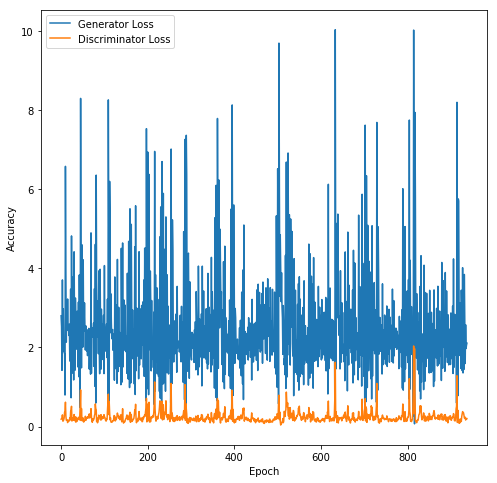

In [18]:
# plot g_loss and d_loss
plt.figure(figsize=(8,8))
plt.plot(g_loss_to_display, label='Generator Loss')
plt.plot(d_loss_to_display, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<hr/>